In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [4]:
#display dataset classes
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

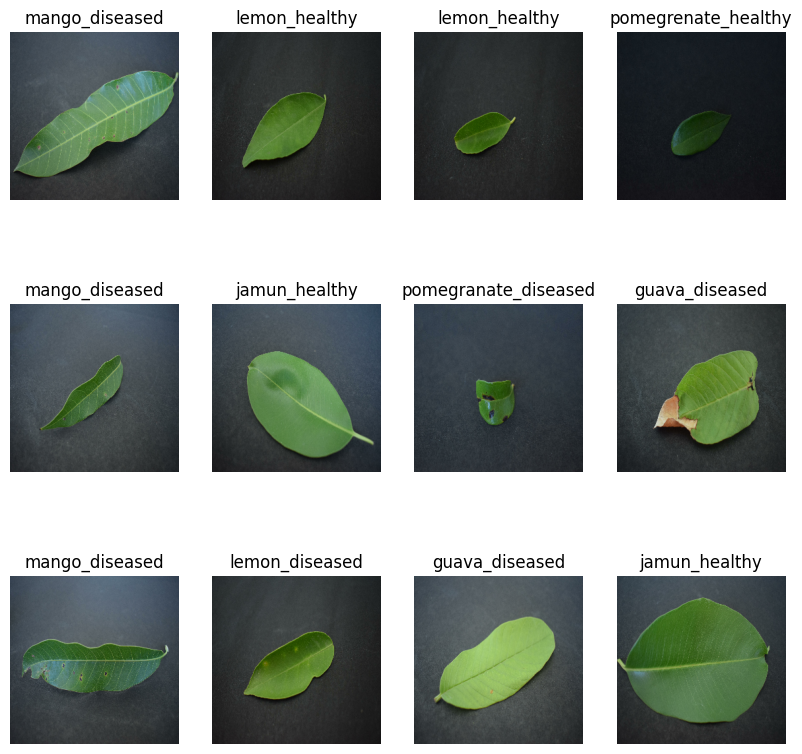

In [5]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [5]:
len(dataset)

72

In [6]:
train_size = 0.8
len(dataset)*train_size

57.6

In [7]:
train_ds = dataset.take(57)
len(train_ds)

57

In [8]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [9]:
val_size=0.1
len(dataset)*val_size

7.2

In [10]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [11]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [12]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(dataset)

72

In [15]:
len(train_ds)

57

In [16]:
len(val_ds)

7

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

In [22]:
for images, labels in normalized_dataset:
    for image in images:
        print(image)

tf.Tensor(
[[[0.19975491 0.28210786 0.35661766]
  [0.20490198 0.28725493 0.36960787]
  [0.21201748 0.2943704  0.36888024]
  ...
  [0.20855546 0.25953585 0.29483   ]
  [0.18734683 0.23832722 0.27362135]
  [0.18014707 0.23112747 0.2664216 ]]

 [[0.1929611  0.2831572  0.35374543]
  [0.19632354 0.27867648 0.3531863 ]
  [0.19975491 0.28210786 0.35661766]
  ...
  [0.19901963 0.25       0.28529415]
  [0.17879903 0.22977942 0.26507354]
  [0.17561276 0.22659315 0.26188728]]

 [[0.22084866 0.31104475 0.38163298]
  [0.1978937  0.28808978 0.358678  ]
  [0.1902344  0.27258733 0.34709713]
  ...
  [0.17475492 0.2257353  0.26102942]
  [0.1642157  0.21519609 0.25049022]
  [0.15944394 0.21042433 0.24571846]]

 ...

 [[0.09889706 0.11458334 0.12634805]
  [0.09695926 0.11264554 0.12441024]
  [0.11453738 0.13022366 0.14198837]
  ...
  [0.10196079 0.10196079 0.10980393]
  [0.1002451  0.11593138 0.11985295]
  [0.11593138 0.13161765 0.13553922]]

 [[0.10919118 0.12487746 0.13664216]
  [0.09963236 0.11531863 0

tf.Tensor(
[[[0.1134038  0.14085479 0.1643842 ]
  [0.11364891 0.14109989 0.1646293 ]
  [0.11136643 0.13881741 0.16234683]
  ...
  [0.10907629 0.13652727 0.1600567 ]
  [0.10638788 0.13383886 0.15736827]
  [0.10921416 0.13666514 0.16019456]]

 [[0.12419578 0.15164676 0.17517617]
  [0.12683824 0.15428923 0.17781864]
  [0.11387102 0.141322   0.16485141]
  ...
  [0.08710938 0.11456037 0.13808978]
  [0.11479014 0.14224112 0.16577053]
  [0.10931373 0.13676472 0.16029413]]

 [[0.11716453 0.14461552 0.16814493]
  [0.10776655 0.13521753 0.15874694]
  [0.12177543 0.14922641 0.17275584]
  ...
  [0.10833334 0.13578433 0.15931374]
  [0.10700828 0.13445926 0.15798867]
  [0.10894608 0.13639706 0.15992647]]

 ...

 [[0.09018842 0.09018842 0.09018842]
  [0.10492495 0.10492495 0.10492495]
  [0.10588236 0.10588236 0.10588236]
  ...
  [0.08627451 0.08627451 0.09411766]
  [0.09352788 0.09352788 0.10137102]
  [0.08627451 0.08627451 0.09411766]]

 [[0.10955883 0.10955883 0.10955883]
  [0.11225491 0.10441177 0

tf.Tensor(
[[[0.16088389 0.19225645 0.2353937 ]
  [0.14008886 0.17538297 0.2106771 ]
  [0.12010571 0.1593214  0.19461551]
  ...
  [0.10843291 0.14372703 0.16333488]
  [0.1004902  0.13578433 0.15539217]
  [0.10343138 0.13088237 0.15441178]]

 [[0.14068629 0.17205884 0.21519609]
  [0.13623622 0.17153034 0.20682447]
  [0.13480394 0.17009805 0.20539217]
  ...
  [0.10968138 0.1449755  0.16458334]
  [0.08786765 0.12316177 0.14276962]
  [0.09105393 0.11850491 0.14203432]]

 [[0.15147826 0.18285081 0.22598806]
  [0.15492494 0.19021907 0.22551319]
  [0.14117648 0.1764706  0.21176472]
  ...
  [0.10175399 0.13704811 0.15665595]
  [0.11225491 0.14754903 0.16715688]
  [0.10368413 0.13897826 0.1585861 ]]

 ...

 [[0.07843138 0.05882353 0.07450981]
  [0.07316177 0.06531863 0.07708333]
  [0.07785693 0.07001379 0.0817785 ]
  ...
  [0.06290594 0.05506281 0.05898438]
  [0.07671569 0.06887256 0.07279412]
  [0.07058824 0.0627451  0.06666667]]

 [[0.07843138 0.05882353 0.07450981]
  [0.07925092 0.07140779 0

tf.Tensor(
[[[0.20385265 0.2587546  0.309735  ]
  [0.18385418 0.230913   0.28581497]
  [0.1819853  0.22904412 0.2839461 ]
  ...
  [0.17991729 0.23089768 0.2936428 ]
  [0.17415749 0.22513787 0.28788298]
  [0.21595436 0.26693475 0.32967985]]

 [[0.18952973 0.23658855 0.29149053]
  [0.20334713 0.25040597 0.30530792]
  [0.19424021 0.24129903 0.296201  ]
  ...
  [0.1764706  0.227451   0.2901961 ]
  [0.17291668 0.22389707 0.28664216]
  [0.17186736 0.22284774 0.28559285]]

 [[0.19963236 0.2466912  0.30159315]
  [0.1867877  0.23384652 0.28874847]
  [0.19138329 0.23844211 0.29334408]
  ...
  [0.17426471 0.22524512 0.29191178]
  [0.16517311 0.2161535  0.2788986 ]
  [0.1612592  0.2122396  0.2749847 ]]

 ...

 [[0.11029413 0.10245099 0.11421569]
  [0.12318475 0.11534161 0.12710632]
  [0.1137255  0.10588236 0.11764707]
  ...
  [0.08917739 0.10094211 0.12054995]
  [0.09529719 0.10706189 0.12666973]
  [0.09191177 0.10367648 0.12328432]]

 [[0.10894608 0.10110295 0.11286765]
  [0.10612746 0.09828432 0

tf.Tensor(
[[[0.1449755  0.19595589 0.258701  ]
  [0.18063727 0.23553923 0.28651962]
  [0.15014553 0.2050475  0.2560279 ]
  ...
  [0.14276196 0.20550705 0.26825216]
  [0.12755822 0.19030333 0.25304842]
  [0.14048713 0.19146754 0.25813422]]

 [[0.16531864 0.21629903 0.27904412]
  [0.17214309 0.22704504 0.27802545]
  [0.15686275 0.21176472 0.2627451 ]
  ...
  [0.13098194 0.19372703 0.25647214]
  [0.13043046 0.19317557 0.25592068]
  [0.14583334 0.19681373 0.2634804 ]]

 [[0.16986062 0.220841   0.2835861 ]
  [0.15465687 0.20955883 0.26053923]
  [0.15138635 0.20628831 0.2572687 ]
  ...
  [0.14489125 0.20763634 0.27038145]
  [0.14558825 0.20833334 0.27107844]
  [0.15047489 0.20145528 0.26812196]]

 ...

 [[0.0762255  0.09191177 0.10367648]
  [0.09460785 0.11029413 0.12205883]
  [0.09019608 0.10588236 0.11764707]
  ...
  [0.0634804  0.07916667 0.09093138]
  [0.07316177 0.08884805 0.10061275]
  [0.058341   0.07402727 0.08579198]]

 [[0.08627451 0.10196079 0.1137255 ]
  [0.08643536 0.10212164 0

tf.Tensor(
[[[0.1680377  0.20333181 0.22293966]
  [0.17922029 0.21451442 0.23412226]
  [0.16860448 0.20389861 0.22350645]
  ...
  [0.15808825 0.18553923 0.20906864]
  [0.16479014 0.19224113 0.21577054]
  [0.15288757 0.18033855 0.20386797]]

 [[0.1699755  0.20526962 0.22487746]
  [0.18541668 0.2207108  0.24816178]
  [0.16210939 0.1974035  0.22485448]
  ...
  [0.16401656 0.19146754 0.21499695]
  [0.16176471 0.1892157  0.21274512]
  [0.14534314 0.17279413 0.19632354]]

 [[0.1838312  0.21912532 0.23873316]
  [0.1658318  0.20112593 0.22857691]
  [0.18129596 0.21659009 0.24404107]
  ...
  [0.15477942 0.1822304  0.20575982]
  [0.15046723 0.17791821 0.20144762]
  [0.16127452 0.1887255  0.21225491]]

 ...

 [[0.15772825 0.15380669 0.17341453]
  [0.14730392 0.14338236 0.16299021]
  [0.14808518 0.14416361 0.16377145]
  ...
  [0.11793812 0.11793812 0.12578125]
  [0.12252605 0.12252605 0.13036919]
  [0.14376533 0.14376533 0.15160847]]

 [[0.14283855 0.13891698 0.15852483]
  [0.13725491 0.13333334 0

tf.Tensor(
[[[0.2286535  0.27571234 0.33845744]
  [0.21568629 0.2627451  0.3254902 ]
  [0.22499235 0.2720512  0.33479628]
  ...
  [0.1872549  0.23823531 0.30098042]
  [0.17962624 0.23060663 0.29335174]
  [0.17281711 0.2237975  0.2865426 ]]

 [[0.22016698 0.2672258  0.32997093]
  [0.22152269 0.2685815  0.3313266 ]
  [0.20433518 0.251394   0.3141391 ]
  ...
  [0.17683825 0.22781864 0.29056373]
  [0.1711627  0.22214308 0.28488818]
  [0.17708334 0.22806373 0.29080883]]

 [[0.22352943 0.27058825 0.33333334]
  [0.22926626 0.27632508 0.33122703]
  [0.21568629 0.2627451  0.3254902 ]
  ...
  [0.17892158 0.22990197 0.29264706]
  [0.16813727 0.21911766 0.28186277]
  [0.16164216 0.21262257 0.27536768]]

 ...

 [[0.14595589 0.14203432 0.16164216]
  [0.1545573  0.15063573 0.17024358]
  [0.15641086 0.17209713 0.18386184]
  ...
  [0.12790288 0.14751074 0.16319701]
  [0.11816024 0.13776809 0.15345436]
  [0.1254902  0.14509805 0.16078432]]

 [[0.12965687 0.14534314 0.15710786]
  [0.15510876 0.1511872  0

tf.Tensor(
[[[0.10467985 0.12428769 0.13997397]
  [0.10901502 0.12862286 0.14430913]
  [0.08688726 0.1064951  0.12218138]
  ...
  [0.08124235 0.09300705 0.1126149 ]
  [0.08112746 0.09289216 0.1125    ]
  [0.08419118 0.09595589 0.11556374]]

 [[0.09803922 0.11764707 0.13333334]
  [0.10539217 0.125      0.14068629]
  [0.08651961 0.10612746 0.12181373]
  ...
  [0.08627451 0.09803922 0.11764707]
  [0.09121478 0.10297948 0.12258732]
  [0.08933824 0.10110295 0.12071079]]

 [[0.10588236 0.1254902  0.14117648]
  [0.11921722 0.13882507 0.15451135]
  [0.106947   0.12655485 0.14224112]
  ...
  [0.0685432  0.08815105 0.10383732]
  [0.08370098 0.09546569 0.11507354]
  [0.07794118 0.08970588 0.10931373]]

 ...

 [[0.08235294 0.07450981 0.08627451]
  [0.08529412 0.07745098 0.08921569]
  [0.08235294 0.07450981 0.08627451]
  ...
  [0.07058824 0.0627451  0.07450981]
  [0.07450981 0.06666667 0.07843138]
  [0.0627451  0.0627451  0.07058824]]

 [[0.08995099 0.08210785 0.09387255]
  [0.08602942 0.07818628 0

tf.Tensor(
[[[0.12982537 0.1768842  0.2396293 ]
  [0.13666514 0.18764554 0.25039065]
  [0.12513022 0.17218904 0.23493415]
  ...
  [0.11803769 0.15725338 0.19646907]
  [0.12130821 0.1605239  0.19973959]
  [0.11938573 0.15860142 0.19389553]]

 [[0.10094211 0.1519225  0.2146676 ]
  [0.13623622 0.18329504 0.24604015]
  [0.14365044 0.19070926 0.25345436]
  ...
  [0.12012102 0.15933672 0.1985524 ]
  [0.11838236 0.15759805 0.19681373]
  [0.10569087 0.14490657 0.18412225]]

 [[0.1398361  0.18689492 0.24964003]
  [0.12779565 0.17485449 0.23759958]
  [0.15122549 0.19828433 0.26102942]
  ...
  [0.11536459 0.15458028 0.19379596]
  [0.1137255  0.15294118 0.19215688]
  [0.11237746 0.15159315 0.19080883]]

 ...

 [[0.06752452 0.05968137 0.07144608]
  [0.05882353 0.0509804  0.0627451 ]
  [0.0627451  0.05490196 0.06666667]
  ...
  [0.07058824 0.07058824 0.07843138]
  [0.07450981 0.07450981 0.08235294]
  [0.08407629 0.08407629 0.09191943]]

 [[0.07144608 0.06360295 0.07536765]
  [0.06519608 0.05735295 0

tf.Tensor(
[[[0.08892464 0.11637562 0.13990504]
  [0.07983303 0.10728402 0.13081342]
  [0.08749235 0.11494333 0.13847274]
  ...
  [0.07990196 0.09950981 0.11519609]
  [0.06211704 0.08172488 0.09741116]
  [0.06911765 0.08872549 0.11225491]]

 [[0.08296569 0.11041667 0.13394609]
  [0.08995099 0.11740196 0.14093138]
  [0.09644608 0.12389707 0.14742649]
  ...
  [0.07389706 0.09350491 0.10919118]
  [0.0627451  0.08235294 0.10588236]
  [0.07450981 0.09411766 0.11764707]]

 [[0.09497549 0.11458334 0.13811275]
  [0.08541667 0.10502452 0.12855393]
  [0.08435202 0.11180301 0.13533242]
  ...
  [0.06907935 0.0886872  0.10437348]
  [0.07671569 0.09632353 0.11985295]
  [0.06531863 0.08492648 0.10845589]]

 ...

 [[0.09583334 0.0879902  0.09975491]
  [0.09019608 0.08235294 0.09411766]
  [0.09411766 0.08627451 0.09803922]
  ...
  [0.07679994 0.06895681 0.08072151]
  [0.07058824 0.0627451  0.08235294]
  [0.06887256 0.06495099 0.08455883]]

 [[0.08933824 0.08149511 0.09325981]
  [0.09028034 0.08243719 0

tf.Tensor(
[[[0.1190717  0.15044425 0.16220896]
  [0.12034314 0.1517157  0.1634804 ]
  [0.11642923 0.14780179 0.15956649]
  ...
  [0.09668352 0.12021293 0.12021293]
  [0.10327053 0.11895681 0.12287838]
  [0.1007353  0.11642157 0.12034314]]

 [[0.10654872 0.13792127 0.14968598]
  [0.11789216 0.14926471 0.16102943]
  [0.11740196 0.14877452 0.16053922]
  ...
  [0.0904182  0.11394762 0.11394762]
  [0.09019608 0.10588236 0.10980393]
  [0.09718138 0.11286765 0.11678922]]

 [[0.11458334 0.14595589 0.1577206 ]
  [0.11629903 0.13590688 0.15159315]
  [0.11258426 0.14395681 0.15572152]
  ...
  [0.09840687 0.11409315 0.11801472]
  [0.10120252 0.11688879 0.12081036]
  [0.09325981 0.10894608 0.11286765]]

 ...

 [[0.09718138 0.08933824 0.09325981]
  [0.09299173 0.0851486  0.08907016]
  [0.10367648 0.09583334 0.09975491]
  ...
  [0.08664216 0.08664216 0.08664216]
  [0.08627451 0.08627451 0.08627451]
  [0.07928922 0.07928922 0.07928922]]

 [[0.08651961 0.07867648 0.08259805]
  [0.09019608 0.08235294 0

tf.Tensor(
[[[0.11313573 0.15627299 0.1798024 ]
  [0.12578891 0.16892618 0.19245559]
  [0.13651961 0.17573531 0.21102943]
  ...
  [0.09397212 0.13318782 0.1724035 ]
  [0.10115656 0.14037225 0.17958795]
  [0.10137102 0.14058672 0.1798024 ]]

 [[0.11759345 0.15680914 0.19210325]
  [0.10637256 0.14558825 0.18088236]
  [0.11004902 0.14926471 0.18455884]
  ...
  [0.1132353  0.152451   0.19166668]
  [0.09436275 0.13357843 0.17279413]
  [0.10644149 0.14565718 0.18487287]]

 [[0.12193628 0.1572304  0.19252452]
  [0.12967984 0.16889554 0.20418966]
  [0.11474419 0.1500383  0.18533243]
  ...
  [0.09554994 0.13476564 0.17398132]
  [0.10014553 0.13936122 0.17857692]
  [0.11066177 0.14987746 0.18909314]]

 ...

 [[0.10808824 0.10416667 0.12769608]
  [0.09375001 0.08982844 0.11335785]
  [0.09987745 0.09595589 0.1194853 ]
  ...
  [0.08043046 0.09219517 0.11180301]
  [0.07843138 0.09019608 0.10980393]
  [0.08235294 0.09411766 0.1137255 ]]

 [[0.08713236 0.08321079 0.1067402 ]
  [0.09411766 0.09019608 0

tf.Tensor(
[[[0.20923714 0.28374696 0.35041362]
  [0.209735   0.2842448  0.35091147]
  [0.22843139 0.3029412  0.36960787]
  ...
  [0.20243567 0.28871018 0.37890628]
  [0.21053922 0.29681376 0.38700983]
  [0.19735755 0.28363207 0.37382814]]

 [[0.19644609 0.2709559  0.33762258]
  [0.23214616 0.30665597 0.37332264]
  [0.19767158 0.2721814  0.33884805]
  ...
  [0.18404566 0.27032018 0.36051625]
  [0.21654414 0.30281866 0.39301473]
  [0.20654872 0.29282326 0.38301933]]

 [[0.20687808 0.2813879  0.34805456]
  [0.21568629 0.2901961  0.35686275]
  [0.24285388 0.31736368 0.38403034]
  ...
  [0.22977942 0.31605393 0.40625003]
  [0.21274512 0.2911765  0.38529414]
  [0.20428923 0.29056373 0.38075984]]

 ...

 [[0.13370098 0.12977941 0.14938727]
  [0.10980393 0.10588236 0.1254902 ]
  [0.12022059 0.11629903 0.13590688]
  ...
  [0.12263328 0.15008426 0.18145682]
  [0.13137256 0.15882353 0.1901961 ]
  [0.12329198 0.15074296 0.18211551]]

 [[0.11703432 0.11311276 0.13272059]
  [0.12414216 0.12022059 0

tf.Tensor(
[[[0.19080883 0.23786767 0.30061278]
  [0.18863359 0.23569241 0.2984375 ]
  [0.20356159 0.25062042 0.31336552]
  ...
  [0.19005822 0.23711705 0.29986215]
  [0.19152115 0.23857997 0.30132508]
  [0.1832644  0.23032324 0.29306835]]

 [[0.19870558 0.24576442 0.30850953]
  [0.21127452 0.25833336 0.32107845]
  [0.2074755  0.25453433 0.3094363 ]
  ...
  [0.19524358 0.2423024  0.3050475 ]
  [0.18284315 0.22990197 0.29264706]
  [0.19294578 0.24000461 0.30274972]]

 [[0.19301471 0.24007355 0.30281866]
  [0.20392159 0.2509804  0.30588236]
  [0.22270988 0.26976871 0.32467067]
  ...
  [0.19779412 0.24485296 0.30759805]
  [0.2022059  0.24926472 0.3120098 ]
  [0.17426471 0.22132355 0.28406864]]

 ...

 [[0.14117648 0.15294118 0.17254902]
  [0.11855087 0.13031557 0.14992341]
  [0.13762255 0.14938727 0.16899511]
  ...
  [0.10775889 0.12344517 0.13520987]
  [0.10465687 0.12034314 0.13210785]
  [0.13112746 0.1272059  0.14681374]]

 [[0.11668199 0.1284467  0.14805454]
  [0.13700981 0.14877452 0

tf.Tensor(
[[[0.14213389 0.16174173 0.17350644]
  [0.1539905  0.17359835 0.18928464]
  [0.14165136 0.1612592  0.17694548]
  ...
  [0.10979627 0.12940411 0.14116882]
  [0.10507813 0.12468597 0.13645068]
  [0.12085631 0.14046416 0.15222886]]

 [[0.14031863 0.15992647 0.17169118]
  [0.13190106 0.1515089  0.16719517]
  [0.14031863 0.15992647 0.17561276]
  ...
  [0.12193628 0.14154413 0.15330884]
  [0.11356465 0.1331725  0.1449372 ]
  [0.11066177 0.13026962 0.14203432]]

 [[0.15428923 0.17389707 0.18566178]
  [0.13602942 0.15563726 0.17132354]
  [0.13517158 0.15477942 0.1704657 ]
  ...
  [0.10751379 0.12712164 0.13888635]
  [0.10566024 0.12526809 0.13703279]
  [0.10980393 0.12941177 0.14117648]]

 ...

 [[0.1072304  0.09938726 0.11115197]
  [0.09325981 0.08541667 0.08933824]
  [0.10616575 0.09832262 0.11008732]
  ...
  [0.07487746 0.07487746 0.07487746]
  [0.09583334 0.0879902  0.09191177]
  [0.08627451 0.07843138 0.08235294]]

 [[0.09878983 0.0909467  0.1027114 ]
  [0.10980393 0.10196079 0

tf.Tensor(
[[[0.11259957 0.13220742 0.1478937 ]
  [0.10883886 0.1284467  0.1402114 ]
  [0.1148361  0.13444394 0.14620864]
  ...
  [0.10051318 0.12796417 0.15149358]
  [0.10651042 0.13396141 0.15749082]
  [0.11433824 0.13394609 0.1574755 ]]

 [[0.11512715 0.134735   0.14649971]
  [0.12283242 0.14244026 0.15420498]
  [0.12191331 0.14152114 0.15328586]
  ...
  [0.11421569 0.14166668 0.16519609]
  [0.10453432 0.1319853  0.15551472]
  [0.09809284 0.11770068 0.14123009]]

 [[0.10233609 0.12194394 0.13370864]
  [0.0964231  0.11603095 0.12779565]
  [0.12822458 0.14783242 0.15959713]
  ...
  [0.09803922 0.1254902  0.14901961]
  [0.10061275 0.12806374 0.15159315]
  [0.10367648 0.12328432 0.14681374]]

 ...

 [[0.09460785 0.08676471 0.09068628]
  [0.09411766 0.08627451 0.09803922]
  [0.09035693 0.08251379 0.0942785 ]
  ...
  [0.07430301 0.06645987 0.07822458]
  [0.08370098 0.07585785 0.08762255]
  [0.07536765 0.06752452 0.07928922]]

 [[0.0947304  0.08688726 0.09865197]
  [0.09019608 0.08235294 0

tf.Tensor(
[[[0.08122703 0.0969133  0.10083487]
  [0.08786765 0.10355393 0.1074755 ]
  [0.08246784 0.09815411 0.10207568]
  ...
  [0.08149511 0.10110295 0.11678922]
  [0.08344057 0.10304841 0.11873469]
  [0.08208487 0.10169271 0.11737899]]

 [[0.07290135 0.08858763 0.0925092 ]
  [0.08884805 0.10453432 0.10845589]
  [0.0786535  0.09433977 0.09826134]
  ...
  [0.0819853  0.10159314 0.11727942]
  [0.08235294 0.10196079 0.11764707]
  [0.07450981 0.09411766 0.10980393]]

 [[0.08186275 0.09754903 0.1014706 ]
  [0.07941177 0.09509805 0.09901962]
  [0.08014707 0.09583334 0.09975491]
  ...
  [0.08627451 0.09803922 0.11764707]
  [0.08235294 0.09411766 0.1137255 ]
  [0.07709099 0.08885571 0.10846355]]

 ...

 [[0.0627451  0.05490196 0.06666667]
  [0.08298867 0.07514553 0.08691024]
  [0.08043046 0.07258732 0.08435202]
  ...
  [0.07279412 0.07279412 0.08063726]
  [0.07058824 0.07058824 0.07843138]
  [0.07279412 0.06495099 0.07671569]]

 [[0.07843138 0.07058824 0.08235294]
  [0.07058824 0.0627451  0

tf.Tensor(
[[[0.1007353  0.12818629 0.1517157 ]
  [0.09741116 0.12486214 0.14839156]
  [0.10635724 0.13380823 0.15733764]
  ...
  [0.11789216 0.15318628 0.18063727]
  [0.11696538 0.15225951 0.17971049]
  [0.11171876 0.14701287 0.17446385]]

 [[0.10488665 0.13233763 0.15586704]
  [0.09583334 0.12328432 0.14681374]
  [0.10058977 0.12804076 0.15157017]
  ...
  [0.10218291 0.13747703 0.16492802]
  [0.10196079 0.13725491 0.16470589]
  [0.10061275 0.13590688 0.16335785]]

 [[0.09803157 0.12548254 0.14901195]
  [0.10588236 0.13333334 0.15686275]
  [0.08700981 0.11446079 0.1379902 ]
  ...
  [0.10367648 0.1389706  0.16642158]
  [0.10627298 0.14156711 0.16901809]
  [0.10281863 0.13811275 0.16556373]]

 ...

 [[0.08149511 0.07365196 0.08541667]
  [0.0918122  0.08396906 0.09573377]
  [0.07843138 0.07058824 0.08235294]
  ...
  [0.06102942 0.06102942 0.06887256]
  [0.0627451  0.0627451  0.07058824]
  [0.07536765 0.07536765 0.08321079]]

 [[0.08254443 0.07470129 0.086466  ]
  [0.07827053 0.0704274  0

tf.Tensor(
[[[0.19659162 0.24365044 0.30639553]
  [0.19155945 0.24253984 0.30528495]
  [0.18920803 0.24018843 0.30293354]
  ...
  [0.17290902 0.23173255 0.30624235]
  [0.1611673  0.21214768 0.27881435]
  [0.1767923  0.22777268 0.29443935]]

 [[0.17697611 0.2279565  0.2907016 ]
  [0.1762255  0.2272059  0.289951  ]
  [0.18786766 0.23884806 0.30159315]
  ...
  [0.16125154 0.22399664 0.28674173]
  [0.18423714 0.23521754 0.3018842 ]
  [0.17058824 0.23333335 0.29607844]]

 [[0.16949296 0.22047336 0.28321847]
  [0.18039216 0.23137257 0.29411766]
  [0.17214309 0.22312348 0.2858686 ]
  ...
  [0.19322152 0.24420191 0.3108686 ]
  [0.17563574 0.23445927 0.30896908]
  [0.1763557  0.23910081 0.3018459 ]]

 ...

 [[0.13945313 0.15906098 0.1825904 ]
  [0.14274664 0.16235448 0.1858839 ]
  [0.13280486 0.1524127  0.17594211]
  ...
  [0.13125001 0.14301471 0.1704657 ]
  [0.12012102 0.13188574 0.15149358]
  [0.12329198 0.14289983 0.1585861 ]]

 [[0.1324755  0.15208334 0.17561276]
  [0.14224112 0.16184896 0

tf.Tensor(
[[[0.08355546 0.16590841 0.24826135]
  [0.08991269 0.17226563 0.2546186 ]
  [0.08943015 0.1717831  0.25413606]
  ...
  [0.08357844 0.16985296 0.26004905]
  [0.09343597 0.17971049 0.26990658]
  [0.07757353 0.16384804 0.246201  ]]

 [[0.07886796 0.16122091 0.24357384]
  [0.08627451 0.16862746 0.2509804 ]
  [0.09377299 0.17612593 0.25847888]
  ...
  [0.10394455 0.19021907 0.28041515]
  [0.07467066 0.16094516 0.25114125]
  [0.08596049 0.172235   0.2624311 ]]

 [[0.08149511 0.16384804 0.246201  ]
  [0.0730622  0.15541515 0.23776808]
  [0.07450981 0.15686275 0.2392157 ]
  ...
  [0.09669118 0.17512256 0.2692402 ]
  [0.0841682  0.16259958 0.25671723]
  [0.08885571 0.16728708 0.26140472]]

 ...

 [[0.07709099 0.10846355 0.15160081]
  [0.07234988 0.10372243 0.14685969]
  [0.07769608 0.10906863 0.15220588]
  ...
  [0.06053922 0.09583334 0.15465687]
  [0.06666667 0.10196079 0.16078432]
  [0.07365196 0.10110295 0.16384804]]

 [[0.08149511 0.11286765 0.1560049 ]
  [0.06425399 0.09562654 0

tf.Tensor(
[[[0.20141698 0.2523974  0.31906405]
  [0.20460325 0.25558364 0.31832877]
  [0.19400276 0.24498317 0.30772826]
  ...
  [0.13835785 0.16580883 0.18933825]
  [0.13522519 0.1705193  0.19012715]
  [0.13688727 0.17218138 0.19178922]]

 [[0.21132813 0.26230854 0.32505363]
  [0.20265779 0.25363818 0.3163833 ]
  [0.19595589 0.24693629 0.3096814 ]
  ...
  [0.12916668 0.1644608  0.18406864]
  [0.12148438 0.1567785  0.17638634]
  [0.13266698 0.1679611  0.18756895]]

 [[0.21004137 0.26102176 0.32376686]
  [0.19754903 0.24852942 0.31127453]
  [0.18709406 0.23807447 0.30081958]
  ...
  [0.13324909 0.1685432  0.18815105]
  [0.14005056 0.17534468 0.19495252]
  [0.12156098 0.15685509 0.17646293]]

 ...

 [[0.09976257 0.09976257 0.1076057 ]
  [0.1034084  0.09556526 0.10732997]
  [0.10755209 0.09970895 0.11147366]
  ...
  [0.11564799 0.11564799 0.12349112]
  [0.10588236 0.10588236 0.1137255 ]
  [0.09410999 0.09410999 0.10195313]]

 [[0.10808824 0.1002451  0.11200981]
  [0.10453432 0.10453432 0

tf.Tensor(
[[[0.2010953  0.2520757  0.3148208 ]
  [0.20763634 0.25861675 0.32136184]
  [0.19574143 0.24672183 0.30946693]
  ...
  [0.15956649 0.2223116  0.2850567 ]
  [0.18658856 0.23756894 0.3042356 ]
  [0.17482385 0.22580424 0.2924709 ]]

 [[0.21090688 0.26188728 0.32463238]
  [0.2074755  0.2584559  0.321201  ]
  [0.20000002 0.2509804  0.3137255 ]
  ...
  [0.1612975  0.2240426  0.2867877 ]
  [0.17340687 0.22438727 0.29105395]
  [0.17732844 0.22830884 0.29497552]]

 [[0.20650277 0.25748315 0.32022828]
  [0.1944853  0.2454657  0.3082108 ]
  [0.19873622 0.24971662 0.31246173]
  ...
  [0.1701823  0.2329274  0.2956725 ]
  [0.16862746 0.21960786 0.28627452]
  [0.17660081 0.2275812  0.2903263 ]]

 ...

 [[0.14117648 0.13725491 0.15686275]
  [0.15870099 0.15477942 0.17438726]
  [0.1764706  0.17254902 0.19215688]
  ...
  [0.13010877 0.14187348 0.16148132]
  [0.11926318 0.13102789 0.15063573]
  [0.12414216 0.13590688 0.15551472]]

 [[0.13914676 0.13522519 0.1587546 ]
  [0.16727942 0.16335785 0

tf.Tensor(
[[[0.23318017 0.29592526 0.35867035]
  [0.24280792 0.2937883  0.3565334 ]
  [0.24597888 0.29695928 0.35970438]
  ...
  [0.17377453 0.22475491 0.26004905]
  [0.17162225 0.22260265 0.25789678]
  [0.17857692 0.2295573  0.26485142]]

 [[0.21188727 0.27463236 0.3334559 ]
  [0.21727942 0.28002453 0.34276962]
  [0.23196232 0.2829427  0.34568784]
  ...
  [0.18041514 0.23139554 0.26668966]
  [0.18255976 0.23354015 0.26883426]
  [0.17109376 0.22207415 0.25736827]]

 [[0.2016008  0.2643459  0.327091  ]
  [0.23014708 0.2928922  0.35563728]
  [0.24942556 0.30040595 0.36315107]
  ...
  [0.1836627  0.23464309 0.26993722]
  [0.17953433 0.23051472 0.26580885]
  [0.17609529 0.22707568 0.2623698 ]]

 ...

 [[0.13639706 0.13639706 0.1442402 ]
  [0.12607998 0.12607998 0.13392311]
  [0.13006282 0.13006282 0.13790596]
  ...
  [0.11115197 0.12683824 0.1307598 ]
  [0.12022059 0.13590688 0.13982844]
  [0.11151961 0.1272059  0.13112746]]

 [[0.13419119 0.13419119 0.14203432]
  [0.12503831 0.12503831 0

tf.Tensor(
[[[0.12367494 0.15504749 0.1668122 ]
  [0.13298868 0.16436122 0.17612593]
  [0.1273361  0.15870865 0.17047335]
  ...
  [0.11801472 0.1454657  0.16899511]
  [0.10970436 0.13715534 0.16068475]
  [0.1007353  0.12818629 0.1517157 ]]

 [[0.12841606 0.15978861 0.17155331]
  [0.1397059  0.17107844 0.18284315]
  [0.12326134 0.1546339  0.1663986 ]
  ...
  [0.11374848 0.14119945 0.16472887]
  [0.11290595 0.14035693 0.16388634]
  [0.10110295 0.12855393 0.15208334]]

 [[0.13677238 0.16814493 0.17990963]
  [0.13590688 0.16727942 0.17904413]
  [0.12834713 0.15971968 0.17148438]
  ...
  [0.1132353  0.14068629 0.1642157 ]
  [0.10245099 0.12990198 0.15343139]
  [0.1063649  0.13381588 0.1573453 ]]

 ...

 [[0.11495864 0.11103708 0.13064492]
  [0.11642157 0.11642157 0.12426471]
  [0.11956955 0.11956955 0.12741269]
  ...
  [0.10551471 0.10159314 0.12120099]
  [0.10884652 0.10492495 0.12453279]
  [0.10147826 0.09755669 0.11716453]]

 [[0.11507354 0.11115197 0.1307598 ]
  [0.12941177 0.12941177 0

tf.Tensor(
[[[0.4012255  0.4522059  0.48750004]
  [0.40297183 0.45395222 0.48924634]
  [0.39743415 0.44841453 0.48370868]
  ...
  [0.3710325  0.41809133 0.47299328]
  [0.36727944 0.41433826 0.46924022]
  [0.35982692 0.40688574 0.4617877 ]]

 [[0.40367648 0.4546569  0.489951  ]
  [0.3935815  0.4445619  0.47985604]
  [0.39950982 0.45049024 0.48578435]
  ...
  [0.37659317 0.423652   0.47855395]
  [0.35457262 0.40163144 0.45653343]
  [0.36102945 0.40808827 0.46299022]]

 [[0.39558825 0.44656867 0.48186278]
  [0.40306374 0.45404413 0.48933828]
  [0.4037148  0.4546952  0.4899893 ]
  ...
  [0.36839002 0.41544887 0.47035083]
  [0.358678   0.40573686 0.46063882]
  [0.36642158 0.41348043 0.4683824 ]]

 ...

 [[0.34730396 0.36299023 0.3669118 ]
  [0.35406712 0.3697534  0.37367496]
  [0.3348882  0.35057446 0.35449603]
  ...
  [0.28770682 0.30731466 0.32300094]
  [0.31125155 0.3308594  0.34654567]
  [0.30023745 0.3198453  0.33553156]]

 [[0.32732844 0.34301472 0.3469363 ]
  [0.327451   0.34313726 0

tf.Tensor(
[[[0.1560049  0.20306374 0.2579657 ]
  [0.1632353  0.21029413 0.26519608]
  [0.15503217 0.20209101 0.25699297]
  ...
  [0.1772978  0.25965074 0.3420037 ]
  [0.18899357 0.2713465  0.35369948]
  [0.18475798 0.2671109  0.34946388]]

 [[0.15483303 0.20189187 0.25679383]
  [0.16834407 0.21540289 0.27030486]
  [0.15343139 0.2004902  0.25539216]
  ...
  [0.18286613 0.26521906 0.34757203]
  [0.19281557 0.2751685  0.35752147]
  [0.18357845 0.2659314  0.34828433]]

 [[0.17217372 0.21923254 0.27413452]
  [0.15590534 0.20296417 0.25786614]
  [0.16405486 0.21111368 0.26601565]
  ...
  [0.17532936 0.2576823  0.34003526]
  [0.17426471 0.25661767 0.3389706 ]
  [0.18394609 0.26629904 0.34865198]]

 ...

 [[0.12634805 0.12242648 0.14595589]
  [0.125      0.12107844 0.14068629]
  [0.11335785 0.12904413 0.14080884]
  ...
  [0.17275584 0.21981466 0.27471662]
  [0.16299021 0.21004903 0.264951  ]
  [0.1442402  0.19129904 0.246201  ]]

 [[0.11029413 0.10637256 0.12990198]
  [0.13072151 0.12679994 0

tf.Tensor(
[[[0.07869945 0.0983073  0.11399357]
  [0.09331343 0.11292127 0.13645068]
  [0.07915901 0.09876686 0.12229627]
  ...
  [0.07181373 0.08357844 0.10318628]
  [0.07531404 0.08707874 0.10668658]
  [0.0639706  0.08357844 0.09926471]]

 [[0.07886796 0.0984758  0.11416208]
  [0.08884805 0.10845589 0.1319853 ]
  [0.08627451 0.10588236 0.12941177]
  ...
  [0.06262255 0.07438726 0.0939951 ]
  [0.06916361 0.08877145 0.10445773]
  [0.06752452 0.08713236 0.10281863]]

 [[0.07892157 0.09852942 0.12205883]
  [0.08627451 0.10588236 0.12941177]
  [0.0807981  0.10040595 0.12393536]
  ...
  [0.06119026 0.0807981  0.09648438]
  [0.05759804 0.06936275 0.08897059]
  [0.06580883 0.08541667 0.10110295]]

 ...

 [[0.08100491 0.07708333 0.09669118]
  [0.08426777 0.0803462  0.09995405]
  [0.0762255  0.07230393 0.09191177]
  ...
  [0.06666667 0.05882353 0.07058824]
  [0.06350338 0.05566024 0.06742495]
  [0.06053922 0.05269608 0.06446079]]

 [[0.09038757 0.086466   0.10607384]
  [0.07928922 0.07536765 0

tf.Tensor(
[[[0.18414523 0.23512563 0.27041975]
  [0.20392159 0.24313727 0.28235295]
  [0.19923408 0.2502145  0.2855086 ]
  ...
  [0.16570926 0.2127681  0.26767007]
  [0.16810663 0.21516545 0.27006742]
  [0.16086091 0.20791975 0.2628217 ]]

 [[0.20766698 0.25864738 0.2939415 ]
  [0.20196846 0.25294885 0.28824297]
  [0.20818782 0.2474035  0.2866192 ]
  ...
  [0.15713084 0.20418966 0.25909162]
  [0.16862746 0.21568629 0.27058825]
  [0.1644608  0.21151961 0.2664216 ]]

 [[0.18162532 0.23260571 0.26789984]
  [0.17845435 0.22943476 0.26472887]
  [0.20155485 0.25253525 0.28782937]
  ...
  [0.16299021 0.21004903 0.264951  ]
  [0.16068475 0.20774359 0.26264554]
  [0.18344824 0.23050706 0.28540903]]

 ...

 [[0.09852942 0.09852942 0.10637256]
  [0.09985448 0.09201134 0.10377605]
  [0.09574909 0.08790595 0.09967066]
  ...
  [0.09227942 0.09227942 0.10012256]
  [0.10196079 0.10196079 0.10980393]
  [0.10281863 0.09889706 0.11850491]]

 [[0.10588236 0.09803922 0.10980393]
  [0.09828432 0.09044118 0

tf.Tensor(
[[[0.18484989 0.22406557 0.26328126]
  [0.19977789 0.23899359 0.27820927]
  [0.19790901 0.23712471 0.2763404 ]
  ...
  [0.1632353  0.19852942 0.23382354]
  [0.15264247 0.18793659 0.2232307 ]
  [0.15320925 0.18850338 0.2237975 ]]

 [[0.19688267 0.23609836 0.27531406]
  [0.1961627  0.24714309 0.2824372 ]
  [0.19583334 0.24681374 0.28210786]
  ...
  [0.16695774 0.20225185 0.23754597]
  [0.14901961 0.18431373 0.21960786]
  [0.1572304  0.19252452 0.22781864]]

 [[0.19166668 0.23088236 0.27009806]
  [0.18129596 0.23227637 0.2675705 ]
  [0.18096662 0.231947   0.26724112]
  ...
  [0.16519609 0.2004902  0.23578432]
  [0.15955883 0.19485295 0.23014708]
  [0.15723807 0.19253218 0.2278263 ]]

 ...

 [[0.1382353  0.1382353  0.14607844]
  [0.1530867  0.1530867  0.16092984]
  [0.14080884 0.14080884 0.14865197]
  ...
  [0.10339309 0.10339309 0.11123622]
  [0.1132353  0.1132353  0.12107844]
  [0.12732078 0.12732078 0.13516392]]

 [[0.13272059 0.13272059 0.14056373]
  [0.14882047 0.14882047 0

tf.Tensor(
[[[0.2392157  0.29411766 0.34509805]
  [0.24132201 0.29622397 0.34720436]
  [0.24313727 0.29803923 0.34901962]
  ...
  [0.19644609 0.2317402  0.25134805]
  [0.18093598 0.2162301  0.24368107]
  [0.18458182 0.21987593 0.24732691]]

 [[0.22433366 0.27531406 0.33805916]
  [0.24056374 0.2954657  0.3464461 ]
  [0.24276963 0.2976716  0.34865198]
  ...
  [0.17637102 0.21166515 0.231273  ]
  [0.18750001 0.22279413 0.24240197]
  [0.1834559  0.21875001 0.246201  ]]

 [[0.22475491 0.2796569  0.33063728]
  [0.23186275 0.2867647  0.33774513]
  [0.23599114 0.2908931  0.3418735 ]
  ...
  [0.18676472 0.22205883 0.24166667]
  [0.1788986  0.21419272 0.23380056]
  [0.18211551 0.21740963 0.24486062]]

 ...

 [[0.11151961 0.12328432 0.14289217]
  [0.12624848 0.13801318 0.15762103]
  [0.12802544 0.14763328 0.16331956]
  ...
  [0.13982844 0.15551472 0.15943629]
  [0.14215687 0.15784314 0.16176471]
  [0.1067402  0.12242648 0.12634805]]

 [[0.11433824 0.12610295 0.1457108 ]
  [0.12030485 0.13206956 0

tf.Tensor(
[[[0.21654414 0.27928925 0.34203434]
  [0.22111674 0.27209714 0.3387638 ]
  [0.2173024  0.2800475  0.3427926 ]
  ...
  [0.1666437  0.22546723 0.29997703]
  [0.1784084  0.2529182  0.31958488]
  [0.18311122 0.24193476 0.3242877 ]]

 [[0.20778954 0.27053463 0.33327973]
  [0.19856772 0.24954812 0.3162148 ]
  [0.19715841 0.25990352 0.3226486 ]
  ...
  [0.17806374 0.23688728 0.31139708]
  [0.18655792 0.24538144 0.31989124]
  [0.17928922 0.23811276 0.31262258]]

 [[0.208701   0.2714461  0.3341912 ]
  [0.22205883 0.28480393 0.34754905]
  [0.21584713 0.27859223 0.34133732]
  ...
  [0.17275584 0.23157936 0.30608916]
  [0.17522213 0.24973194 0.31639862]
  [0.17818628 0.2526961  0.31936276]]

 ...

 [[0.14509805 0.14509805 0.15294118]
  [0.13946079 0.13553922 0.15514706]
  [0.13557751 0.13165595 0.15126379]
  ...
  [0.12185203 0.11793046 0.1375383 ]
  [0.11629903 0.11237746 0.1319853 ]
  [0.09680607 0.11249235 0.12425705]]

 [[0.11740196 0.1134804  0.13308825]
  [0.14611673 0.14219517 0

tf.Tensor(
[[[0.13684131 0.18390013 0.24664524]
  [0.14749542 0.18278953 0.2494562 ]
  [0.14019608 0.1754902  0.24215688]
  ...
  [0.13138022 0.1705959  0.20589003]
  [0.12709866 0.16239278 0.1976869 ]
  [0.13069087 0.165985   0.20127912]]

 [[0.141682   0.18874082 0.2514859 ]
  [0.14918046 0.18447459 0.25114125]
  [0.1416437  0.17693782 0.24360448]
  ...
  [0.1259804  0.16519609 0.2004902 ]
  [0.12516086 0.16437654 0.19967066]
  [0.12806374 0.16335785 0.19865197]]

 [[0.13945313 0.18651196 0.24925706]
  [0.13191637 0.16721049 0.23387715]
  [0.13583028 0.1711244  0.23779106]
  ...
  [0.12797949 0.1632736  0.19856772]
  [0.11119793 0.15041362 0.18570773]
  [0.12414216 0.16335785 0.19865197]]

 ...

 [[0.08417586 0.08025429 0.09986214]
  [0.09019608 0.09019608 0.09803922]
  [0.0942402  0.0942402  0.10208334]
  ...
  [0.07058824 0.07058824 0.07843138]
  [0.06666667 0.06666667 0.07450981]
  [0.05968137 0.05968137 0.06752452]]

 [[0.09411766 0.08627451 0.09803922]
  [0.08578432 0.08578432 0

tf.Tensor(
[[[0.14149816 0.16502759 0.16502759]
  [0.13357843 0.15710786 0.15710786]
  [0.1299173  0.1534467  0.1534467 ]
  ...
  [0.10955117 0.12523745 0.13700216]
  [0.11312807 0.12881434 0.13273591]
  [0.09985448 0.11554076 0.11946233]]

 [[0.13357843 0.15710786 0.15710786]
  [0.14154413 0.16507354 0.16507354]
  [0.1329657  0.15649511 0.15649511]
  ...
  [0.11335785 0.12904413 0.1329657 ]
  [0.11458334 0.13026962 0.13419119]
  [0.11134345 0.12702973 0.1309513 ]]

 [[0.12977175 0.14545804 0.14937961]
  [0.1476486  0.17117801 0.17117801]
  [0.13112746 0.15465687 0.15465687]
  ...
  [0.11356465 0.12925093 0.1331725 ]
  [0.1125     0.12818629 0.13210785]
  [0.11851257 0.13419884 0.13812041]]

 ...

 [[0.08921569 0.08137255 0.08529412]
  [0.1137255  0.10588236 0.10980393]
  [0.10196079 0.09411766 0.09803922]
  ...
  [0.08386183 0.07601869 0.07994026]
  [0.09411766 0.09411766 0.09411766]
  [0.08627451 0.08627451 0.08627451]]

 [[0.09497549 0.08713236 0.09105393]
  [0.10980393 0.10196079 0

tf.Tensor(
[[[0.12902115 0.21529566 0.30549175]
  [0.13793659 0.2242111  0.3144072 ]
  [0.13470435 0.22097887 0.31117496]
  ...
  [0.15633427 0.24407937 0.36809132]
  [0.12836245 0.1989507  0.27738208]
  [0.13090535 0.20149358 0.27992496]]

 [[0.13308825 0.23112747 0.31740198]
  [0.1464461  0.2327206  0.3229167 ]
  [0.16100645 0.24728096 0.3296339 ]
  ...
  [0.14211091 0.2205423  0.26250002]
  [0.13958333 0.21409315 0.2807598 ]
  [0.12205883 0.19656864 0.2632353 ]]

 [[0.14532782 0.24336705 0.32964155]
  [0.16338083 0.24965535 0.33985144]
  [0.12585784 0.21213236 0.30232844]
  ...
  [0.12863818 0.19922642 0.2776578 ]
  [0.13923867 0.21374848 0.28041515]
  [0.10097274 0.17548254 0.24214922]]

 ...

 [[0.07928922 0.07536765 0.09497549]
  [0.08568475 0.08176318 0.10137102]
  [0.07058824 0.06666667 0.08627451]
  ...
  [0.0956725  0.12312347 0.15449603]
  [0.0884804  0.12377451 0.15122549]
  [0.09804688 0.12549786 0.15687041]]

 [[0.07867648 0.07475491 0.09436275]
  [0.07843138 0.07450981 0

tf.Tensor(
[[[0.2082108  0.30625    0.3846814 ]
  [0.22433366 0.31060818 0.3929611 ]
  [0.21147366 0.30166975 0.37225798]
  ...
  [0.1665288  0.22143078 0.27241117]
  [0.15563726 0.21053922 0.24583335]
  [0.15120251 0.20610449 0.25708488]]

 [[0.21734835 0.31538758 0.39381894]
  [0.22303922 0.30931374 0.39166668]
  [0.22708334 0.31335786 0.3957108 ]
  ...
  [0.15686275 0.21176472 0.24705884]
  [0.1699755  0.22487746 0.2601716 ]
  [0.13419119 0.18909314 0.24007355]]

 [[0.18125    0.27928925 0.3577206 ]
  [0.23071386 0.31698838 0.39934132]
  [0.2214461  0.3077206  0.39007354]
  ...
  [0.16691178 0.22181374 0.25710785]
  [0.1567402  0.21164218 0.24693629]
  [0.14901961 0.20392159 0.2392157 ]]

 ...

 [[0.11017158 0.12977941 0.15330884]
  [0.12156864 0.14117648 0.16470589]
  [0.1317785  0.15138635 0.17491576]
  ...
  [0.07977942 0.09546569 0.1072304 ]
  [0.08676471 0.10245099 0.10637256]
  [0.08579198 0.10147826 0.11324296]]

 [[0.11248469 0.13209254 0.15562195]
  [0.11164217 0.13125001 0

tf.Tensor(
[[[0.20291056 0.26565567 0.3244792 ]
  [0.19411    0.2568551  0.3196002 ]
  [0.2019608  0.2647059  0.327451  ]
  ...
  [0.19481465 0.26932445 0.33599114]
  [0.17874542 0.25325522 0.31992188]
  [0.16953892 0.24404873 0.3107154 ]]

 [[0.19656864 0.25931373 0.32205886]
  [0.18810509 0.2508502  0.3135953 ]
  [0.20404413 0.26678923 0.32953432]
  ...
  [0.17316177 0.24767159 0.31433827]
  [0.18014707 0.25465688 0.32132354]
  [0.1879902  0.26250002 0.32916668]]

 [[0.20294885 0.26569396 0.32843906]
  [0.1991192  0.2618643  0.3246094 ]
  [0.2072687  0.2700138  0.3327589 ]
  ...
  [0.19387256 0.26838237 0.33504903]
  [0.18210785 0.25661767 0.32328433]
  [0.19276196 0.26727176 0.33393845]]

 ...

 [[0.10589002 0.12157629 0.133341  ]
  [0.11985295 0.11593138 0.13553922]
  [0.13370098 0.12977941 0.14938727]
  ...
  [0.08970588 0.10539217 0.11715687]
  [0.09316024 0.10884652 0.12061122]
  [0.10196079 0.11764707 0.12941177]]

 [[0.12683824 0.12291668 0.14252453]
  [0.11813726 0.11421569 0

tf.Tensor(
[[[0.07002145 0.08962929 0.11315871]
  [0.06004902 0.08750001 0.11102942]
  [0.06605393 0.09350491 0.11703432]
  ...
  [0.06532629 0.08493414 0.10062041]
  [0.07480852 0.09441637 0.11010264]
  [0.05968137 0.07928922 0.09497549]]

 [[0.07512255 0.0947304  0.11825981]
  [0.07974112 0.1071921  0.13072151]
  [0.08210785 0.10955883 0.13308825]
  ...
  [0.06382506 0.08343291 0.09911919]
  [0.0629902  0.08259805 0.09828432]
  [0.06973039 0.08933824 0.10502452]]

 [[0.07488512 0.09449296 0.11802237]
  [0.06848193 0.08808977 0.11161918]
  [0.07977942 0.1072304  0.1307598 ]
  ...
  [0.06715687 0.08676471 0.10245099]
  [0.06017157 0.07977942 0.09546569]
  [0.05575981 0.07536765 0.09105393]]

 ...

 [[0.0884804  0.08063726 0.09240197]
  [0.08063726 0.07279412 0.08455883]
  [0.08835785 0.08051471 0.09227942]
  ...
  [0.08455883 0.08063726 0.10416667]
  [0.08235294 0.07843138 0.10196079]
  [0.07633273 0.07241116 0.09594057]]

 [[0.08186275 0.07401961 0.08578432]
  [0.07843138 0.07058824 0

tf.Tensor(
[[[0.18217678 0.21747091 0.2449219 ]
  [0.17377453 0.20906864 0.24436276]
  [0.18298101 0.21827513 0.24572612]
  ...
  [0.15356159 0.18101257 0.20454198]
  [0.15635724 0.18380822 0.20733763]
  [0.14630055 0.17375155 0.19728096]]

 [[0.16279872 0.19809285 0.23338696]
  [0.18786766 0.22316177 0.2584559 ]
  [0.18088236 0.21617648 0.24362746]
  ...
  [0.1593597  0.18681067 0.21034008]
  [0.15036766 0.17781864 0.20134805]
  [0.15404412 0.18149512 0.20502453]]

 [[0.16911    0.20440412 0.2318551 ]
  [0.1704657  0.20968139 0.2449755 ]
  [0.18615197 0.2214461  0.2567402 ]
  ...
  [0.1322687  0.15971968 0.18324909]
  [0.1502451  0.1776961  0.2012255 ]
  [0.13467371 0.16212471 0.18565412]]

 ...

 [[0.14596355 0.14596355 0.15380669]
  [0.15343139 0.15343139 0.16127452]
  [0.152451   0.152451   0.16029413]
  ...
  [0.11458334 0.11458334 0.12242648]
  [0.12473193 0.12473193 0.13257506]
  [0.11017924 0.11017924 0.11017924]]

 [[0.12941177 0.12941177 0.13725491]
  [0.14632353 0.14632353 0

tf.Tensor(
[[[0.21899511 0.28174022 0.3444853 ]
  [0.20605087 0.26879597 0.33154106]
  [0.21826747 0.28101256 0.3437577 ]
  ...
  [0.19045651 0.2532016  0.3159467 ]
  [0.17731312 0.24005823 0.30280334]
  [0.17071079 0.2334559  0.29227942]]

 [[0.22615656 0.28890166 0.35164678]
  [0.22479321 0.28753832 0.3502834 ]
  [0.21115197 0.27389708 0.33664218]
  ...
  [0.17610295 0.23884806 0.30159315]
  [0.18999694 0.25274205 0.31548715]
  [0.19282323 0.25556833 0.31439188]]

 [[0.21616116 0.27890626 0.34165138]
  [0.22970283 0.29244792 0.35519305]
  [0.21577054 0.27851564 0.34126073]
  ...
  [0.19779412 0.24877453 0.3154412 ]
  [0.17130056 0.23404567 0.29679078]
  [0.2112975  0.2740426  0.3367877 ]]

 ...

 [[0.12377451 0.11985295 0.13946079]
  [0.12081036 0.11688879 0.13649663]
  [0.12512256 0.12120099 0.14080884]
  ...
  [0.09840687 0.09840687 0.10625   ]
  [0.0911535  0.08723193 0.10683978]
  [0.09669118 0.09669118 0.10453432]]

 [[0.1254902  0.12156864 0.14117648]
  [0.11629903 0.11237746 0

tf.Tensor(
[[[0.15392157 0.1892157  0.21666668]
  [0.14509805 0.18039216 0.20784315]
  [0.14387256 0.17916667 0.20661765]
  ...
  [0.15307905 0.20013788 0.25503984]
  [0.15440412 0.20146294 0.2563649 ]
  [0.15215227 0.1992111  0.25411308]]

 [[0.12850031 0.16379443 0.19124542]
  [0.15661766 0.19191177 0.21936275]
  [0.13000154 0.16529566 0.19274664]
  ...
  [0.15208334 0.19914217 0.25404415]
  [0.15833335 0.20539217 0.26029414]
  [0.15294118 0.20000002 0.25490198]]

 [[0.14338236 0.17867649 0.20612746]
  [0.13333334 0.16862746 0.19607845]
  [0.14885877 0.18415289 0.21160388]
  ...
  [0.16551778 0.21257661 0.27532172]
  [0.15504749 0.20210633 0.25700828]
  [0.14976257 0.19682139 0.25172335]]

 ...

 [[0.11286765 0.10502452 0.11678922]
  [0.10845589 0.10061275 0.11237746]
  [0.10265779 0.09481465 0.10657936]
  ...
  [0.12830883 0.14007354 0.15968138]
  [0.11115197 0.12291668 0.14252453]
  [0.12377451 0.13553922 0.15514706]]

 [[0.11029413 0.10245099 0.11421569]
  [0.09044118 0.08259805 0

tf.Tensor(
[[[0.2313649  0.25097275 0.26273745]
  [0.21062349 0.23023133 0.24199603]
  [0.21544118 0.23504904 0.24681374]
  ...
  [0.18453586 0.2041437  0.21590841]
  [0.19135265 0.20703892 0.21096049]
  [0.19909622 0.21478249 0.21870406]]

 [[0.2207108  0.24031864 0.25208336]
  [0.21568629 0.23529413 0.24705884]
  [0.22350645 0.2431143  0.254879  ]
  ...
  [0.19605547 0.21958488 0.21958488]
  [0.18039216 0.19607845 0.20000002]
  [0.20251992 0.2182062  0.22212777]]

 [[0.23529413 0.25490198 0.26666668]
  [0.22686122 0.24646907 0.2582338 ]
  [0.21560204 0.23520988 0.24697459]
  ...
  [0.19501379 0.21070008 0.21462165]
  [0.1901961  0.2137255  0.2137255 ]
  [0.20392159 0.21960786 0.22352943]]

 ...

 [[0.17819394 0.17819394 0.18603708]
  [0.20065871 0.20065871 0.20850185]
  [0.17189799 0.17189799 0.17189799]
  ...
  [0.16148132 0.16148132 0.16148132]
  [0.16029413 0.16029413 0.16029413]
  [0.14251687 0.14251687 0.14251687]]

 [[0.2029412  0.2029412  0.21078433]
  [0.19081649 0.19081649 0

tf.Tensor(
[[[0.08406863 0.09975491 0.11151961]
  [0.09812348 0.11380975 0.12557445]
  [0.0757353  0.09142157 0.10318628]
  ...
  [0.07365196 0.10110295 0.12463236]
  [0.07776502 0.105216   0.1287454 ]
  [0.06090686 0.08835785 0.11188726]]

 [[0.08748469 0.10317096 0.11493567]
  [0.10036765 0.11605393 0.12781863]
  [0.08235294 0.09803922 0.10980393]
  ...
  [0.08161765 0.10906863 0.13259804]
  [0.07732844 0.10477941 0.12830883]
  [0.07566637 0.10311735 0.12664676]]

 [[0.09106158 0.10674786 0.11851257]
  [0.06936275 0.08504903 0.09681373]
  [0.06932446 0.08501073 0.09677543]
  ...
  [0.07214308 0.09959406 0.12312347]
  [0.07068781 0.09813879 0.1216682 ]
  [0.06741729 0.09486827 0.11839768]]

 ...

 [[0.04485294 0.03700981 0.04877451]
  [0.04705883 0.03921569 0.0509804 ]
  [0.05882353 0.0509804  0.0627451 ]
  ...
  [0.05882353 0.07450981 0.08627451]
  [0.05747549 0.05355392 0.07316177]
  [0.06666667 0.0627451  0.08235294]]

 [[0.05882353 0.0509804  0.0627451 ]
  [0.04705883 0.03921569 0

tf.Tensor(
[[[0.20095743 0.23625155 0.2558594 ]
  [0.19329812 0.22859223 0.24820007]
  [0.18552391 0.22081803 0.24042587]
  ...
  [0.13469669 0.15430455 0.16606925]
  [0.1248698  0.14447765 0.15624236]
  [0.13210785 0.1517157  0.1634804 ]]

 [[0.18263635 0.21793047 0.23753831]
  [0.21425399 0.24954812 0.26915595]
  [0.19681373 0.23210786 0.2517157 ]
  ...
  [0.15151656 0.1711244  0.1828891 ]
  [0.14117648 0.16078432 0.17254902]
  [0.12941177 0.14901961 0.16078432]]

 [[0.20564492 0.24093905 0.2605469 ]
  [0.20071232 0.23600645 0.25561428]
  [0.21168047 0.24697459 0.26658243]
  ...
  [0.13590688 0.15551472 0.16727942]
  [0.12301625 0.1426241  0.1543888 ]
  [0.14165902 0.16126686 0.17303157]]

 ...

 [[0.09938726 0.11507354 0.12683824]
  [0.11259957 0.10867801 0.12828586]
  [0.10196079 0.11764707 0.12941177]
  ...
  [0.11813726 0.13382354 0.13774511]
  [0.12277114 0.13845742 0.14237899]
  [0.11017924 0.1258655  0.12978707]]

 [[0.08254443 0.0982307  0.10999541]
  [0.0889323  0.10461857 0

tf.Tensor(
[[[0.17588083 0.21509652 0.25431222]
  [0.16293658 0.21391699 0.2492111 ]
  [0.16474418 0.21572459 0.2510187 ]
  ...
  [0.17575063 0.22280945 0.28555456]
  [0.16925552 0.21631435 0.27905944]
  [0.17375155 0.22081037 0.28355548]]

 [[0.16108304 0.21206343 0.24735755]
  [0.17471662 0.22569701 0.26099113]
  [0.16076134 0.21174175 0.24703586]
  ...
  [0.17279413 0.21985295 0.28259805]
  [0.18390779 0.23096661 0.29371172]
  [0.17218138 0.2192402  0.2819853 ]]

 [[0.16641392 0.2056296  0.2448453 ]
  [0.15536919 0.20634958 0.2416437 ]
  [0.16605394 0.21703433 0.25232846]
  ...
  [0.17361367 0.22459407 0.28733918]
  [0.17254902 0.21960786 0.28235295]
  [0.17513022 0.22218904 0.28493413]]

 ...

 [[0.10281863 0.10281863 0.11066177]
  [0.09583334 0.09583334 0.10367648]
  [0.10780485 0.09996171 0.11172642]
  ...
  [0.12385877 0.12385877 0.1317019 ]
  [0.10980393 0.10980393 0.11764707]
  [0.10196079 0.10196079 0.10980393]]

 [[0.11109835 0.10325521 0.11501992]
  [0.09546569 0.09546569 0

tf.Tensor(
[[[0.09931067 0.11499694 0.11891851]
  [0.10563726 0.12132353 0.12524511]
  [0.1148361  0.13052237 0.1266008 ]
  ...
  [0.08713236 0.10281863 0.11458334]
  [0.10630362 0.1219899  0.1337546 ]
  [0.09622397 0.11191024 0.12367494]]

 [[0.09748009 0.11316637 0.11708794]
  [0.10845589 0.12414216 0.12806374]
  [0.10575981 0.12144609 0.11752452]
  ...
  [0.10196079 0.11764707 0.12941177]
  [0.10882354 0.12450981 0.13627452]
  [0.09828432 0.11397059 0.11789216]]

 [[0.10588236 0.12156864 0.1254902 ]
  [0.11887255 0.13455883 0.1384804 ]
  [0.11315105 0.12883732 0.13275889]
  ...
  [0.0879902  0.10367648 0.11544118]
  [0.09669118 0.11237746 0.12414216]
  [0.09497549 0.11066177 0.12242648]]

 ...

 [[0.08541667 0.06580883 0.08149511]
  [0.07977942 0.07193628 0.08370098]
  [0.08627451 0.07843138 0.09019608]
  ...
  [0.07450981 0.06666667 0.07058824]
  [0.07843138 0.07058824 0.07450981]
  [0.06838236 0.06053922 0.07230393]]

 [[0.07843138 0.07058824 0.08235294]
  [0.08627451 0.07843138 0

tf.Tensor(
[[[0.14536612 0.18066025 0.20811123]
  [0.14669119 0.1819853  0.21727942]
  [0.12962623 0.16492036 0.20021448]
  ...
  [0.11495098 0.14240196 0.17377453]
  [0.11491269 0.14236367 0.17373623]
  [0.10191484 0.12936582 0.16073836]]

 [[0.1375     0.17279413 0.20808825]
  [0.14093138 0.1762255  0.21151961]
  [0.13688727 0.17218138 0.2074755 ]
  ...
  [0.12845436 0.15590534 0.1872779 ]
  [0.1071921  0.13464308 0.16601564]
  [0.11960785 0.14705883 0.17843138]]

 [[0.13322611 0.16852023 0.1959712 ]
  [0.12845436 0.16374847 0.1990426 ]
  [0.12761949 0.16683519 0.2021293 ]
  ...
  [0.11776961 0.1452206  0.17659315]
  [0.09524357 0.13053769 0.15798867]
  [0.09669118 0.1319853  0.15943629]]

 ...

 [[0.11813726 0.11421569 0.13382354]
  [0.11066177 0.1067402  0.12634805]
  [0.08986674 0.10555301 0.11731771]
  ...
  [0.09154412 0.1072304  0.11899511]
  [0.09375001 0.10943628 0.12120099]
  [0.08541667 0.10110295 0.11286765]]

 [[0.11397059 0.11004902 0.12965687]
  [0.10204504 0.11773132 0

tf.Tensor(
[[[0.2017157  0.23700982 0.29583335]
  [0.19068629 0.2259804  0.28480393]
  [0.19093904 0.23799787 0.29289985]
  ...
  [0.18002452 0.23100491 0.2976716 ]
  [0.18161766 0.23259805 0.29926473]
  [0.17828585 0.22926626 0.29593292]]

 [[0.19975491 0.23504904 0.29387257]
  [0.19199602 0.22729015 0.28611368]
  [0.18000154 0.22706036 0.28196234]
  ...
  [0.18429075 0.23527116 0.30193782]
  [0.18688726 0.23786767 0.30453435]
  [0.1809896  0.23196998 0.29863665]]

 [[0.20784315 0.24313727 0.3019608 ]
  [0.19005056 0.22534469 0.2841682 ]
  [0.1704274  0.21748623 0.2723882 ]
  ...
  [0.17908242 0.23006281 0.2967295 ]
  [0.19162072 0.24260111 0.3092678 ]
  [0.18479627 0.23577666 0.30244333]]

 ...

 [[0.15343139 0.14950982 0.16911766]
  [0.14117648 0.13725491 0.15686275]
  [0.13014707 0.1262255  0.14583334]
  ...
  [0.11801472 0.13370098 0.1454657 ]
  [0.14693628 0.16262256 0.17438726]
  [0.13650429 0.15219057 0.16395529]]

 [[0.16004904 0.15612745 0.17573531]
  [0.14469211 0.14077054 0

tf.Tensor(
[[[0.06370252 0.0911535  0.11468291]
  [0.05906863 0.08651961 0.11004902]
  [0.04975491 0.07720589 0.1007353 ]
  ...
  [0.05671722 0.07632507 0.09985448]
  [0.05043658 0.07004443 0.09357384]
  [0.04764859 0.06725644 0.09078585]]

 [[0.05766698 0.08511796 0.10864737]
  [0.04604014 0.07349112 0.09702053]
  [0.05808824 0.08553922 0.10906863]
  ...
  [0.05061275 0.07022059 0.09375001]
  [0.04963236 0.0692402  0.09276962]
  [0.05490196 0.07450981 0.09803922]]

 [[0.06360295 0.09105393 0.11458334]
  [0.05232843 0.07977942 0.10330883]
  [0.06176471 0.08921569 0.11274511]
  ...
  [0.0509804  0.07058824 0.09411766]
  [0.04887408 0.06848193 0.09201134]
  [0.04877451 0.06838236 0.09191177]]

 ...

 [[0.05882353 0.0509804  0.07058824]
  [0.05737592 0.04953279 0.06914063]
  [0.05690105 0.04905791 0.06866575]
  ...
  [0.05490196 0.04705883 0.06666667]
  [0.05490196 0.04705883 0.06666667]
  [0.04791667 0.04007353 0.05968137]]

 [[0.05434283 0.0464997  0.06610754]
  [0.05931373 0.05147059 0

tf.Tensor(
[[[0.1511489  0.23350185 0.30801165]
  [0.167716   0.25006896 0.32457876]
  [0.15860908 0.24880517 0.3193934 ]
  ...
  [0.1438649  0.19092372 0.2458257 ]
  [0.14404872 0.1989507  0.24993108]
  [0.13821232 0.18527114 0.24017312]]

 [[0.16164216 0.24399512 0.31850493]
  [0.14142157 0.23161766 0.3022059 ]
  [0.14997703 0.24017312 0.31076136]
  ...
  [0.15210631 0.19916515 0.25406712]
  [0.1451823  0.19224113 0.24714309]
  [0.13147978 0.17853862 0.23344058]]

 [[0.15687041 0.2470665  0.31765473]
  [0.13323377 0.22342986 0.2940181 ]
  [0.15943629 0.24963237 0.32022062]
  ...
  [0.14996171 0.19702055 0.2519225 ]
  [0.12781863 0.17487746 0.22977942]
  [0.148269   0.19532783 0.2502298 ]]

 ...

 [[0.10234375 0.1219516  0.14548102]
  [0.10980393 0.12941177 0.15294118]
  [0.11507354 0.13468137 0.1582108 ]
  ...
  [0.08235294 0.09803922 0.10196079]
  [0.06100644 0.07669272 0.08061428]
  [0.07058824 0.08627451 0.09019608]]

 [[0.10171569 0.12132353 0.14485295]
  [0.10539217 0.125      0

tf.Tensor(
[[[0.19068629 0.24166667 0.27303922]
  [0.19051012 0.24149051 0.27286306]
  [0.2014706  0.252451   0.28382355]
  ...
  [0.20219824 0.24141392 0.2806296 ]
  [0.19026503 0.24124542 0.27653953]
  [0.19564186 0.23485754 0.27407324]]

 [[0.20588237 0.25686276 0.2882353 ]
  [0.19767158 0.24865198 0.28002453]
  [0.20500155 0.25598195 0.2873545 ]
  ...
  [0.18541668 0.22463237 0.26384807]
  [0.18039216 0.23137257 0.26666668]
  [0.20281863 0.24203433 0.28125003]]

 [[0.21176472 0.2509804  0.28627452]
  [0.19352789 0.23274358 0.2680377 ]
  [0.20939799 0.24861369 0.2839078 ]
  ...
  [0.2016774  0.2408931  0.28010878]
  [0.1947304  0.23394608 0.27316177]
  [0.16469823 0.21567863 0.25097275]]

 ...

 [[0.11937041 0.13505669 0.1468214 ]
  [0.12453279 0.14021906 0.15198377]
  [0.13370098 0.14938727 0.16115198]
  ...
  [0.13092066 0.13092066 0.1387638 ]
  [0.12156864 0.12156864 0.12941177]
  [0.11495864 0.11495864 0.12280178]]

 [[0.10164676 0.11733303 0.12909774]
  [0.11875001 0.13443628 0

tf.Tensor(
[[[0.13674174 0.18772213 0.25046724]
  [0.14437807 0.19535847 0.25810358]
  [0.15423562 0.205216   0.2679611 ]
  ...
  [0.13554688 0.18652728 0.25319394]
  [0.1217448  0.1727252  0.23939186]
  [0.13804382 0.18902421 0.25569087]]

 [[0.14056373 0.19154413 0.25428924]
  [0.14816177 0.19914217 0.26188728]
  [0.16423868 0.21521907 0.27796417]
  ...
  [0.13666514 0.18764554 0.25431222]
  [0.14963236 0.20061275 0.26727942]
  [0.13252911 0.18350951 0.2501762 ]]

 [[0.14901961 0.19607845 0.25882354]
  [0.13894762 0.18992801 0.25267312]
  [0.13733916 0.18831956 0.25106466]
  ...
  [0.13704811 0.1880285  0.25469518]
  [0.13382354 0.18480393 0.2514706 ]
  [0.15034468 0.20132507 0.26799175]]

 ...

 [[0.12463236 0.13639706 0.1560049 ]
  [0.12990198 0.14166668 0.16911766]
  [0.1134421  0.13304995 0.15657936]
  ...
  [0.10817249 0.13562347 0.16699603]
  [0.1137255  0.14117648 0.17254902]
  [0.11544118 0.14289217 0.17426471]]

 [[0.10637256 0.11813726 0.14558825]
  [0.11004902 0.12181373 0

tf.Tensor(
[[[0.15039064 0.22097887 0.29941025]
  [0.14595589 0.22830884 0.30281866]
  [0.14813879 0.23049174 0.30500156]
  ...
  [0.13504137 0.20955117 0.2683747 ]
  [0.13793659 0.21244639 0.27126992]
  [0.14636949 0.2091146  0.2718597 ]]

 [[0.1327742  0.21512716 0.28963697]
  [0.1384421  0.22079505 0.29530486]
  [0.14414063 0.22649358 0.3010034 ]
  ...
  [0.12801778 0.19076288 0.25350797]
  [0.16552544 0.22827055 0.29101565]
  [0.15257354 0.21531864 0.27806374]]

 [[0.13944547 0.22179842 0.29630822]
  [0.13590688 0.22610295 0.29669118]
  [0.15906864 0.24142158 0.31593138]
  ...
  [0.1261872  0.1889323  0.2516774 ]
  [0.13112746 0.19387256 0.25661767]
  [0.13776043 0.20050552 0.26325062]]

 ...

 [[0.09019608 0.10980393 0.13333334]
  [0.09803922 0.11764707 0.14117648]
  [0.09256281 0.11217066 0.13570006]
  ...
  [0.07843138 0.09411766 0.10588236]
  [0.08492648 0.10061275 0.11237746]
  [0.07794884 0.09363512 0.10539982]]

 [[0.09735754 0.11696538 0.1404948 ]
  [0.09411766 0.1137255  0

tf.Tensor(
[[[0.13325675 0.14894302 0.15286459]
  [0.13345589 0.14914216 0.15306373]
  [0.12770374 0.14339001 0.14731158]
  ...
  [0.12779565 0.14348193 0.15524665]
  [0.12359835 0.13928463 0.15104933]
  [0.11975338 0.13543965 0.14720435]]

 [[0.12653953 0.1422258  0.14614737]
  [0.14093138 0.15661766 0.16053922]
  [0.13085939 0.14654566 0.15046723]
  ...
  [0.11801472 0.13370098 0.1454657 ]
  [0.12822458 0.14391086 0.15567556]
  [0.13602942 0.1517157  0.1634804 ]]

 [[0.13419119 0.14987746 0.15379903]
  [0.13742341 0.15310968 0.15703125]
  [0.13517158 0.15085785 0.15477942]
  ...
  [0.12778033 0.1434666  0.15523133]
  [0.14064033 0.1563266  0.16809131]
  [0.14339001 0.1590763  0.17084101]]

 ...

 [[0.13161765 0.13161765 0.13946079]
  [0.1272059  0.1272059  0.13504903]
  [0.12263328 0.11871171 0.13831955]
  ...
  [0.11033242 0.11033242 0.11817556]
  [0.11237746 0.11237746 0.12022059]
  [0.1137255  0.1137255  0.12156864]]

 [[0.14632353 0.14632353 0.15416667]
  [0.12414216 0.12022059 0

tf.Tensor(
[[[0.17350644 0.21272214 0.2519378 ]
  [0.15703891 0.19625461 0.2354703 ]
  [0.16973805 0.20895375 0.24816944]
  ...
  [0.16373315 0.20294885 0.24216454]
  [0.16141239 0.19278494 0.2359222 ]
  [0.15661766 0.1879902  0.23112747]]

 [[0.16188726 0.20110296 0.24031864]
  [0.18133426 0.22054996 0.25976565]
  [0.17232691 0.20369945 0.24683672]
  ...
  [0.18323377 0.22244947 0.26166514]
  [0.1709559  0.20232844 0.2454657 ]
  [0.1759804  0.20735295 0.25049022]]

 [[0.17561276 0.21482845 0.25404415]
  [0.18529412 0.22450982 0.26372552]
  [0.1701823  0.20939799 0.24861369]
  ...
  [0.16250001 0.2017157  0.24093139]
  [0.1661535  0.20144762 0.23674174]
  [0.15379903 0.18909314 0.22438727]]

 ...

 [[0.1132353  0.10539217 0.125     ]
  [0.12156864 0.1137255  0.1254902 ]
  [0.12941177 0.12156864 0.13333334]
  ...
  [0.11094517 0.11094517 0.1187883 ]
  [0.10183824 0.10183824 0.10968138]
  [0.08272825 0.08272825 0.09057139]]

 [[0.10980393 0.10196079 0.12156864]
  [0.12414216 0.11629903 0

tf.Tensor(
[[[0.19767158 0.2721814  0.33884805]
  [0.20678617 0.28129598 0.34796265]
  [0.21028647 0.28479627 0.35146296]
  ...
  [0.18762256 0.24644609 0.3209559 ]
  [0.16474418 0.22356772 0.29807752]
  [0.16161919 0.22044273 0.29495254]]

 [[0.22670038 0.3012102  0.36787686]
  [0.20523132 0.27974114 0.3464078 ]
  [0.2074755  0.2819853  0.34865198]
  ...
  [0.17242648 0.23125002 0.30575982]
  [0.164951   0.22377452 0.29828432]
  [0.16403954 0.22286306 0.29737288]]

 [[0.19656098 0.27107078 0.33773747]
  [0.19892004 0.27342987 0.34009653]
  [0.21662839 0.2911382  0.35780486]
  ...
  [0.17034315 0.22916669 0.3036765 ]
  [0.16460632 0.22342986 0.29793966]
  [0.1834559  0.23443629 0.3089461 ]]

 ...

 [[0.12241882 0.11849725 0.14202666]
  [0.13026962 0.12634805 0.14595589]
  [0.1254902  0.12156864 0.14117648]
  ...
  [0.08982844 0.10551471 0.11727942]
  [0.10732997 0.12301625 0.13478096]
  [0.10808824 0.12377451 0.13553922]]

 [[0.11894149 0.11501992 0.13854933]
  [0.12287838 0.11895681 0

tf.Tensor(
[[[0.09051777 0.12581189 0.14541973]
  [0.08205424 0.11734835 0.1369562 ]
  [0.0871247  0.12241882 0.14202666]
  ...
  [0.07868414 0.10613512 0.12966453]
  [0.07935815 0.10680914 0.13033855]
  [0.07365196 0.10502452 0.11678922]]

 [[0.09056373 0.12585784 0.1454657 ]
  [0.08909314 0.12438726 0.1439951 ]
  [0.08259805 0.11789216 0.1375    ]
  ...
  [0.07453278 0.10590534 0.11767004]
  [0.0692402  0.10061275 0.11237746]
  [0.07757353 0.10502452 0.12855393]]

 [[0.09192709 0.11937807 0.14290749]
  [0.0923024  0.11975338 0.14328279]
  [0.09391085 0.12136184 0.14489125]
  ...
  [0.08541667 0.11286765 0.13639706]
  [0.0692402  0.10061275 0.11237746]
  [0.07928922 0.1067402  0.13026962]]

 ...

 [[0.09240197 0.0884804  0.11200981]
  [0.09250154 0.08857997 0.11210938]
  [0.10772059 0.10379902 0.12732844]
  ...
  [0.0627451  0.07450981 0.09411766]
  [0.06215534 0.07784161 0.08960631]
  [0.06446079 0.0762255  0.09583334]]

 [[0.09100031 0.08707874 0.11060815]
  [0.09395681 0.09003524 0

tf.Tensor(
[[[0.16083027 0.1961244  0.23141852]
  [0.19096968 0.2262638  0.2615579 ]
  [0.1713312  0.20662531 0.24191944]
  ...
  [0.1579274  0.1971431  0.23635878]
  [0.15605852 0.19527422 0.2344899 ]
  [0.16176471 0.19313727 0.23627453]]

 [[0.19534315 0.23063727 0.2659314 ]
  [0.1709559  0.20625001 0.24154413]
  [0.17669272 0.21198684 0.24728096]
  ...
  [0.17193629 0.21115197 0.25036767]
  [0.15690105 0.19611675 0.23533243]
  [0.16526502 0.19663757 0.23977482]]

 [[0.18517157 0.2204657  0.2557598 ]
  [0.19340535 0.22869946 0.2639936 ]
  [0.1706342  0.20592833 0.24122244]
  ...
  [0.13525583 0.17447151 0.21368721]
  [0.16058518 0.19980086 0.23901656]
  [0.16470589 0.19607845 0.2392157 ]]

 ...

 [[0.12634805 0.12634805 0.13419119]
  [0.12338389 0.12338389 0.13122703]
  [0.12920497 0.12920497 0.13704811]
  ...
  [0.10955883 0.10955883 0.11740196]
  [0.10578278 0.10578278 0.11362593]
  [0.1076057  0.1076057  0.11544884]]

 [[0.1254902  0.11764707 0.12941177]
  [0.11507354 0.11507354 0

tf.Tensor(
[[[0.08421416 0.08421416 0.08421416]
  [0.09950981 0.09950981 0.09950981]
  [0.08382353 0.08382353 0.08382353]
  ...
  [0.08591453 0.1016008  0.10552237]
  [0.09075522 0.10644149 0.11036306]
  [0.09019608 0.1137255  0.1137255 ]]

 [[0.08694088 0.08694088 0.08694088]
  [0.07867648 0.07867648 0.07867648]
  [0.08235294 0.08235294 0.08235294]
  ...
  [0.08235294 0.09803922 0.10196079]
  [0.08243719 0.10596661 0.10596661]
  [0.08627451 0.10980393 0.10980393]]

 [[0.07144608 0.07144608 0.07144608]
  [0.08627451 0.08627451 0.08627451]
  [0.0879902  0.0879902  0.0879902 ]
  ...
  [0.08782936 0.10351563 0.1074372 ]
  [0.09095436 0.10664063 0.1105622 ]
  [0.09411766 0.10980393 0.1137255 ]]

 ...

 [[0.09632353 0.0884804  0.09240197]
  [0.09938726 0.09154412 0.09546569]
  [0.07487746 0.06703432 0.07095589]
  ...
  [0.07316177 0.06531863 0.0692402 ]
  [0.09105393 0.08321079 0.08713236]
  [0.0762255  0.06838236 0.07230393]]

 [[0.10593598 0.09809284 0.10201441]
  [0.09922642 0.09138328 0

tf.Tensor(
[[[0.8175016  0.81358004 0.7939722 ]
  [0.8183824  0.8183824  0.78700984]
  [0.8171569  0.8171569  0.78578436]
  ...
  [0.1833027  0.2342831  0.2970282 ]
  [0.18988205 0.24086246 0.30360755]
  [0.18649665 0.23747703 0.30022213]]

 [[0.8196079  0.81568635 0.7960785 ]
  [0.8196079  0.8196079  0.78823537]
  [0.8232844  0.8232844  0.79191184]
  ...
  [0.17804076 0.22902115 0.29176626]
  [0.1764706  0.227451   0.2901961 ]
  [0.1764706  0.22352943 0.28627452]]

 [[0.8196079  0.81568635 0.7960785 ]
  [0.8235295  0.8196079  0.8000001 ]
  [0.79366577 0.79366577 0.74660695]
  ...
  [0.19174327 0.24664524 0.29762563]
  [0.17389707 0.22487746 0.28762257]
  [0.17034315 0.21740197 0.28014708]]

 ...

 [[0.14251687 0.15820314 0.16996785]
  [0.15720743 0.15328586 0.1728937 ]
  [0.16593139 0.16200982 0.18553923]
  ...
  [0.12585784 0.1454657  0.16115198]
  [0.14375001 0.16335785 0.17904413]
  [0.13944547 0.15905333 0.1747396 ]]

 [[0.14404872 0.159735   0.1714997 ]
  [0.14007354 0.15575981 0

tf.Tensor(
[[[0.15347734 0.18092832 0.20445773]
  [0.1497396  0.17719057 0.20071998]
  [0.16190258 0.18935357 0.21288298]
  ...
  [0.10499388 0.13244486 0.15597427]
  [0.1322304  0.15968138 0.18321079]
  [0.12715228 0.15460326 0.17813267]]

 [[0.15612745 0.18357845 0.20710786]
  [0.16580883 0.19325982 0.21678923]
  [0.15320925 0.18066025 0.20418966]
  ...
  [0.11076134 0.13821232 0.16174173]
  [0.12741269 0.15486367 0.17839308]
  [0.13338695 0.16083793 0.18436736]]

 [[0.1442402  0.17169118 0.1952206 ]
  [0.16041668 0.18786766 0.21139707]
  [0.12671569 0.15416667 0.1776961 ]
  ...
  [0.12193628 0.14938727 0.17291668]
  [0.13478096 0.16223194 0.18576135]
  [0.11850491 0.14595589 0.1694853 ]]

 ...

 [[0.11641391 0.10857078 0.12033548]
  [0.12183671 0.12183671 0.12967984]
  [0.12790288 0.12790288 0.13574603]
  ...
  [0.10245099 0.10245099 0.11029413]
  [0.09803922 0.09803922 0.10588236]
  [0.09191943 0.09191943 0.09976257]]

 [[0.12568168 0.11783855 0.12960325]
  [0.12454811 0.11670497 0

tf.Tensor(
[[[0.13573837 0.19848347 0.26122856]
  [0.12249541 0.1852405  0.24798562]
  [0.1241345  0.1868796  0.24962471]
  ...
  [0.11887255 0.15416667 0.18161766]
  [0.12072611 0.15602022 0.18347122]
  [0.12941177 0.16470589 0.19215688]]

 [[0.11936275 0.18210785 0.24485296]
  [0.13733916 0.20008427 0.26282936]
  [0.14176625 0.20058978 0.27509958]
  ...
  [0.11112899 0.14642312 0.1738741 ]
  [0.12205883 0.15735295 0.18480393]
  [0.12745099 0.1627451  0.1901961 ]]

 [[0.13639706 0.19914217 0.26188728]
  [0.12894456 0.19168966 0.25443476]
  [0.14322151 0.20596662 0.26871172]
  ...
  [0.11920191 0.15449603 0.18194701]
  [0.11715687 0.152451   0.17990197]
  [0.12990198 0.16519609 0.19264707]]

 ...

 [[0.11850491 0.13811275 0.16164216]
  [0.10759804 0.1272059  0.1507353 ]
  [0.09775583 0.11736367 0.14089309]
  ...
  [0.1002451  0.11593138 0.12769608]
  [0.0795573  0.09524357 0.10700828]
  [0.07450981 0.09019608 0.10196079]]

 [[0.10281863 0.12242648 0.14595589]
  [0.10187653 0.12148438 0

tf.Tensor(
[[[0.17482385 0.22188267 0.28462777]
  [0.18161766 0.22867648 0.2914216 ]
  [0.191682   0.23874082 0.30148593]
  ...
  [0.17341453 0.23223807 0.30674788]
  [0.17043506 0.2292586  0.3037684 ]
  [0.16044731 0.21927084 0.29378065]]

 [[0.17922029 0.22627912 0.28902423]
  [0.1894225  0.23648132 0.2913833 ]
  [0.19144456 0.23850338 0.3012485 ]
  ...
  [0.17994793 0.23877145 0.31328127]
  [0.1752451  0.23406865 0.30857846]
  [0.15735295 0.21617648 0.29068628]]

 [[0.17157629 0.21863513 0.28138024]
  [0.17514554 0.22220436 0.28494945]
  [0.18517157 0.23223041 0.29497552]
  ...
  [0.1709176  0.22974113 0.30425093]
  [0.17534468 0.23416822 0.30867803]
  [0.19227177 0.24325216 0.31776196]]

 ...

 [[0.11764707 0.12941177 0.14901961]
  [0.1125     0.12426471 0.14387256]
  [0.12156864 0.13333334 0.15294118]
  ...
  [0.10502452 0.12463236 0.14816177]
  [0.09244792 0.11205576 0.13558517]
  [0.1137255  0.14117648 0.16470589]]

 [[0.11200981 0.12377451 0.14338236]
  [0.12532936 0.13709407 0

tf.Tensor(
[[[0.10196079 0.11764707 0.12156864]
  [0.07738205 0.09306832 0.09698989]
  [0.08383119 0.09951747 0.10343904]
  ...
  [0.09291514 0.10860141 0.12036612]
  [0.09208793 0.10777421 0.11953892]
  [0.09924173 0.11492801 0.12669271]]

 [[0.08235294 0.09803922 0.10196079]
  [0.08643536 0.10212164 0.1060432 ]
  [0.07475491 0.09044118 0.09436275]
  ...
  [0.09056373 0.10625    0.11801472]
  [0.08627451 0.10196079 0.1137255 ]
  [0.09355852 0.1092448  0.12100951]]

 [[0.08014707 0.09583334 0.09975491]
  [0.0817402  0.09742647 0.10134804]
  [0.08235294 0.09803922 0.10196079]
  ...
  [0.09240197 0.10808824 0.11985295]
  [0.08445926 0.10014553 0.11191024]
  [0.08235294 0.09803922 0.10980393]]

 ...

 [[0.06236979 0.05452666 0.06629136]
  [0.05882353 0.0509804  0.0627451 ]
  [0.05882353 0.0509804  0.0627451 ]
  ...
  [0.08553922 0.09730393 0.11691177]
  [0.08228401 0.09404872 0.11365657]
  [0.0627451  0.07450981 0.09411766]]

 [[0.05796569 0.05012255 0.06188726]
  [0.05625    0.04840687 0

tf.Tensor(
[[[0.19428617 0.28056067 0.36291364]
  [0.19446999 0.2807445  0.36309746]
  [0.20942862 0.30746785 0.38589922]
  ...
  [0.16862746 0.22352943 0.27450982]
  [0.17325369 0.22815566 0.27913603]
  [0.1706342  0.22553617 0.27651656]]

 [[0.18891698 0.2751915  0.35754445]
  [0.20808825 0.29436275 0.37671572]
  [0.21531864 0.31335786 0.39178923]
  ...
  [0.16717985 0.22208181 0.2730622 ]
  [0.17732844 0.23223041 0.2832108 ]
  [0.18632814 0.2412301  0.2922105 ]]

 [[0.19388022 0.28015473 0.36250767]
  [0.22342986 0.30970436 0.39205733]
  [0.23100491 0.32904413 0.4074755 ]
  ...
  [0.16188726 0.21678923 0.26776963]
  [0.15880056 0.21370253 0.26468292]
  [0.18432139 0.23922336 0.29020375]]

 ...

 [[0.1251149  0.14080118 0.15256588]
  [0.12291668 0.13860294 0.15036766]
  [0.1252834  0.13704811 0.15665595]
  ...
  [0.09375001 0.10943628 0.12120099]
  [0.07441024 0.09009651 0.10186122]
  [0.08429075 0.09997703 0.11174174]]

 [[0.12261796 0.13830423 0.15006894]
  [0.11613818 0.12790288 0

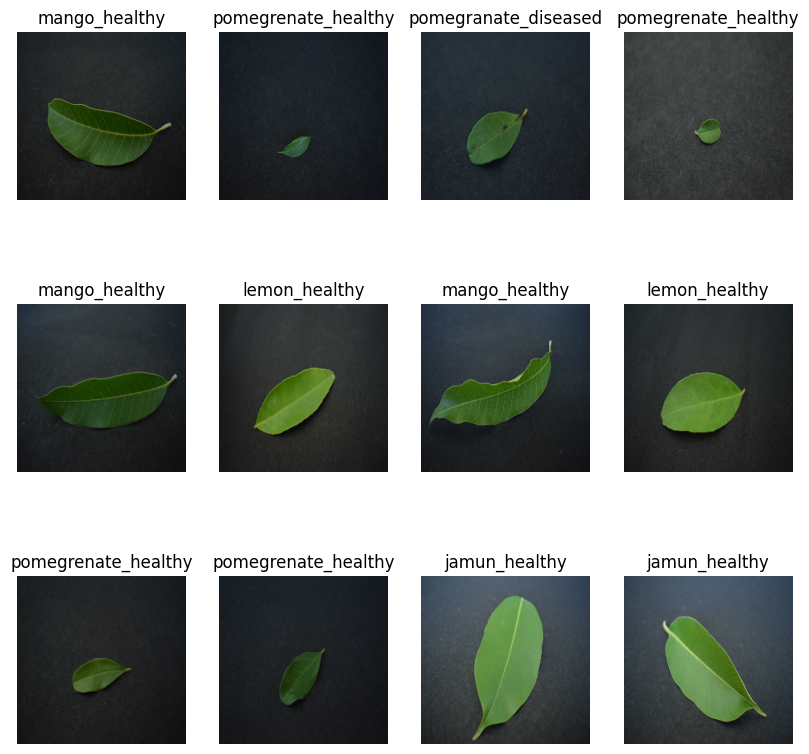

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

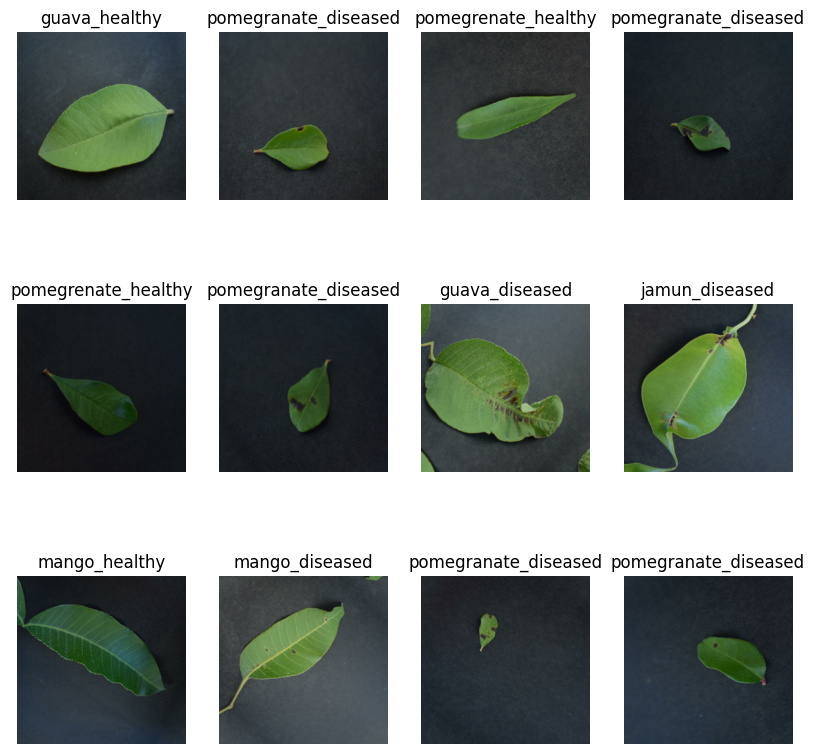

In [25]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 125s 1s/step - loss: 2.2450 - accuracy: 0.2226 - val_loss: 1.7485 - val_accuracy: 0.3080
Epoch 2/30
57/57 [==============================] - 41s 722ms/step - loss: 1.4860 - accuracy: 0.4468 - val_loss: 1.1319 - val_accuracy: 0.6250
Epoch 3/30
57/57 [==============================] - 40s 704ms/step - loss: 1.1001 - accuracy: 0.5833 - val_loss: 0.9122 - val_accuracy: 0.6741
Epoch 4/30
57/57 [==============================] - 40s 701ms/step - loss: 0.9016 - accuracy: 0.6782 - val_loss: 0.8105 - val_accuracy: 0.7009
Epoch 5/30
57/57 [==============================] - 39s 685ms/step - loss: 0.7734 - accuracy: 0.7072 - val_loss: 0.7180 - val_accuracy: 0.7232
Epoch 6/30
57/57 [==============================] - 39s 685ms/step - loss: 0.7948 - accuracy: 0.7018 - val_loss: 0.8333 - val_accuracy: 0.6429
Epoch 7/30
57/57 [==============================] - 39s 685ms/step - loss: 0.6593 - accuracy: 0.7643 - val_loss: 0.9059 - val_accuracy: 0.6250
E

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 28s 159ms/step - loss: 0.3324 - accuracy: 0.8750


In [28]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 18s 308ms/step - loss: 0.3300 - accuracy: 0.8794


In [29]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 1s 155ms/step - loss: 0.3714 - accuracy: 0.8750


In [30]:
score4 = model.evaluate(dataset)

72/72 [==============================] - 34s 425ms/step - loss: 0.3499 - accuracy: 0.8759


In [31]:
scores

[0.33241507411003113, 0.875]

In [32]:
scores2

[0.3299800157546997, 0.8793859481811523]

In [33]:
scores3

[0.37139177322387695, 0.875]

In [34]:
score4

[0.34990593791007996, 0.875934898853302]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 57}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

30

In [40]:
history.history['loss'][:5]

[2.244959592819214,
 1.4859554767608643,
 1.1000874042510986,
 0.9016305208206177,
 0.7733579874038696]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

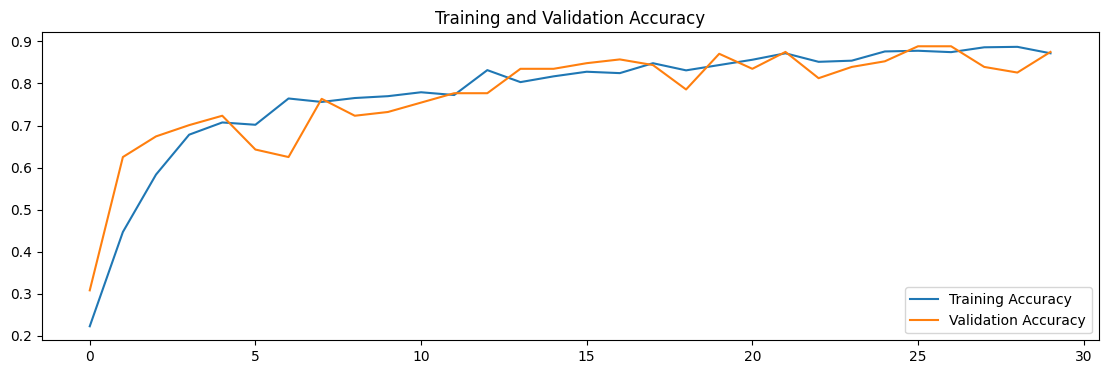

In [42]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

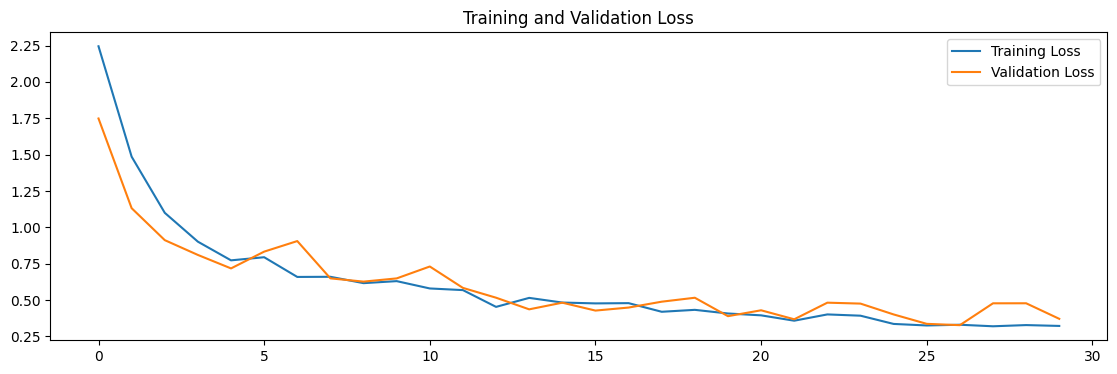

In [43]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: lemon_healthy
1/1 [==============================] - 0s 224ms/step
predicted label: lemon_healthy


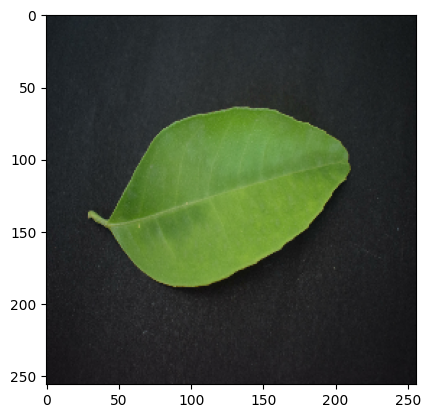

In [112]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
#Test - Accuracy curve for particular class


# class_index = 5  # Index of the desired class
# class_accuracy = history.history['accuracy'][class_index]



# epochs = EPOCHS

# plt.plot(epochs, class_accuracy, label='Class Accuracy')
# plt.title('Accuracy Curve - Class {}'.format(class_index))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


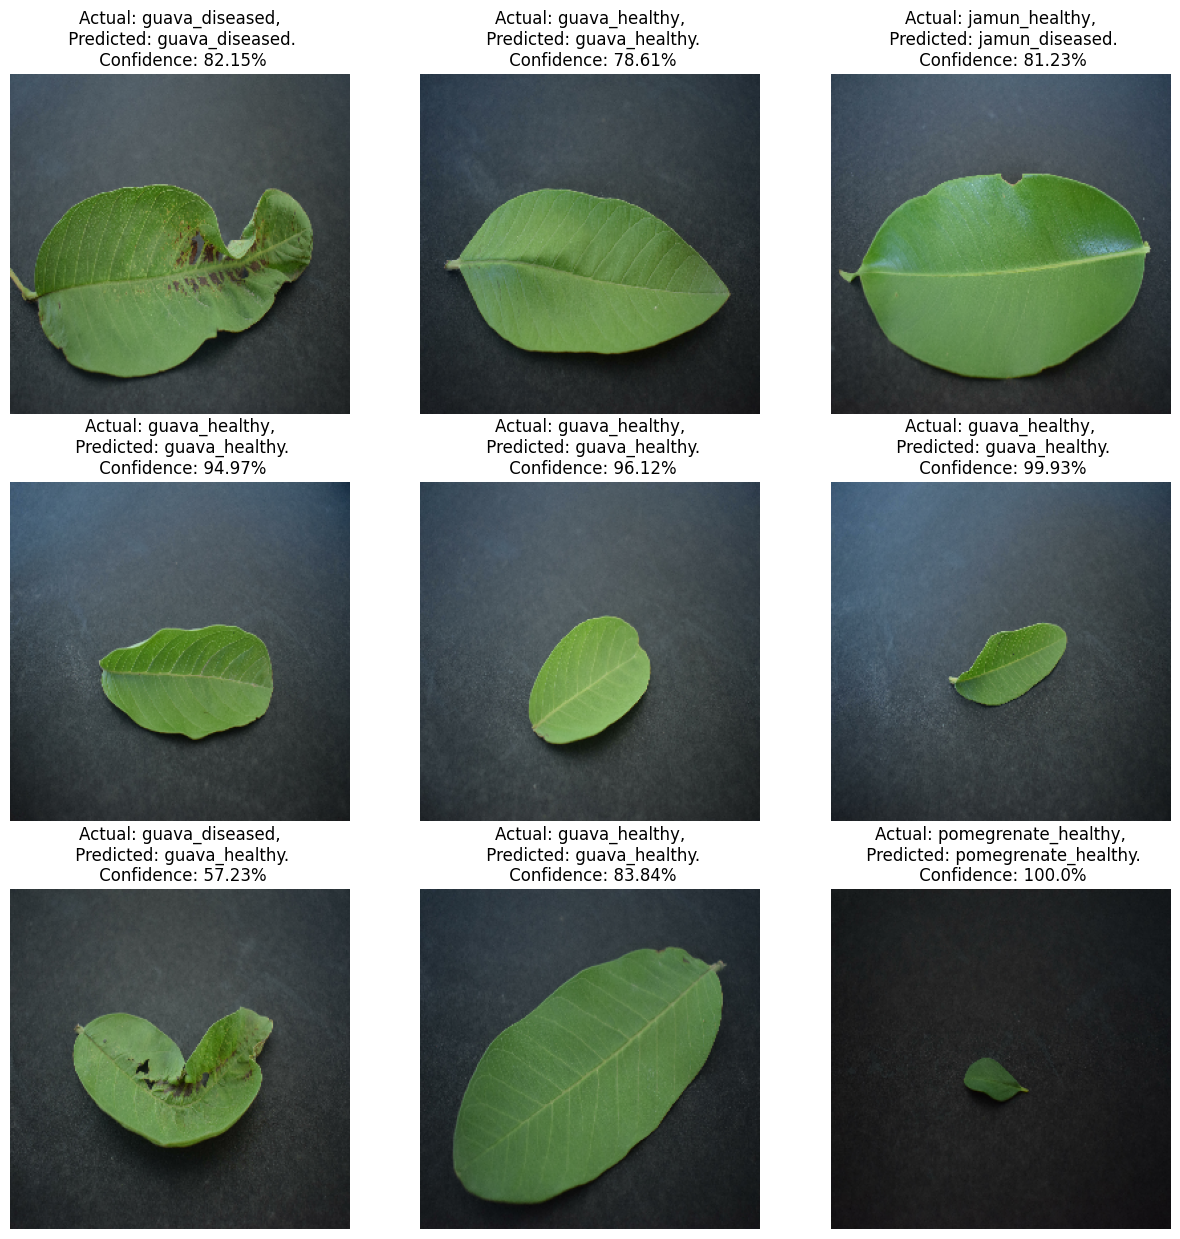

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 1s 150ms/step


In [47]:
print(y_pred_prob)

[[8.21540177e-01 1.40039194e-02 2.37213802e-02 ... 1.43085357e-08
  3.99635125e-09 7.87350452e-09]
 [3.24240391e-05 7.86079347e-01 2.01082826e-01 ... 1.35749602e-07
  1.40145909e-10 7.16957994e-15]
 [2.34514242e-04 1.41126034e-03 8.12305927e-01 ... 1.77934947e-08
  1.28929864e-12 8.77897134e-15]
 ...
 [5.43019087e-06 3.20711583e-02 7.42077816e-07 ... 7.76358619e-02
  8.87958765e-01 2.32544914e-03]
 [1.37233045e-02 1.65344530e-03 5.54896379e-03 ... 1.02307413e-05
  1.07252481e-06 4.99600856e-06]
 [1.01537665e-03 5.59716579e-03 9.93025422e-01 ... 8.55500363e-14
  3.92616452e-12 6.64819114e-16]]


In [48]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [49]:
print(y_pred_labels)

[0 1 2 1 1 1 1 1 9 6 2 2 9 1 2 4 8 2 2 6 7 5 2 4 8 9 1 7 1 6 6 1 2 6 5 2 7
 0 2 2 7 9 2 2 6 1 6 2 9 1 1 9 2 2 5 6 9 1 1 5 1 8 0 0 4 1 2 6 2 8 2 9 9 5
 2 5 7 5 7 1 7 6 1 5 7 8 8 6 3 9 3 2 2 3 6 3 6 4 9 8 1 2 2 5 3 2 1 9 6 1 2
 7 9 9 6 3 5 2 8 6 9 7 9 2 2 8 2 5 5 6 2 2 3 6 6 3 0 0 2 9 2 8 9 1 1 8 1 8
 8 2 6 8 2 1 5 0 3 6 1 7 5 9 1 9 6 1 2 7 5 1 1 8 2 7 3 0 4 8 2 1 2 3 2 2 8
 1 8 4 8 9 2 4 8 3 2 8 5 9 1 6 6 7 7 5 2 2 2 3 1 0 2 7 0 2 2 3 6 7 9 3 9 9
 2 4 1 1 5 2 3 8 9 7 6 2 9 1 6 3 6 1 8 1 6 2 1 9 2 9 1 6 2 6 4 8 6 2]


In [50]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [51]:
print(y_true_labels)

[6 2 9 8 1 2 2 5 3 2 1 9 0 1 2 7 9 9 6 2 5 2 8 6 9 7 9 2 2 8 3 5 5 9 1 9 6
 1 2 7 5 0 0 8 0 7 3 0 4 8 3 1 1 3 2 2 8 2 8 4 8 9 2 4 8 3 5 8 5 9 1 6 6 7
 7 5 2 2 3 3 1 0 2 7 0 3 2 3 6 7 9 3 9 9 2 4 4 1 2 6 2 8 2 9 9 5 2 5 7 5 7
 0 7 6 1 5 7 8 8 6 3 9 3 2 2 3 6 3 1 1 5 2 3 8 9 7 6 2 9 1 6 3 6 1 8 1 6 2
 1 9 2 9 0 6 3 6 5 8 6 2 5 6 2 2 3 6 6 3 0 0 3 9 2 8 9 3 7 8 0 8 8 0 6 8 2
 1 5 0 3 6 1 7 3 6 5 3 7 0 2 3 7 9 2 2 6 1 6 2 9 1 3 9 2 3 5 6 9 1 1 5 1 8
 0 0 0 1 3 1 1 1 0 1 9 6 2 2 9 0 2 4 6 2 3 6 7 5 2 4 8 9 1 7 1 6 6 1]


In [52]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

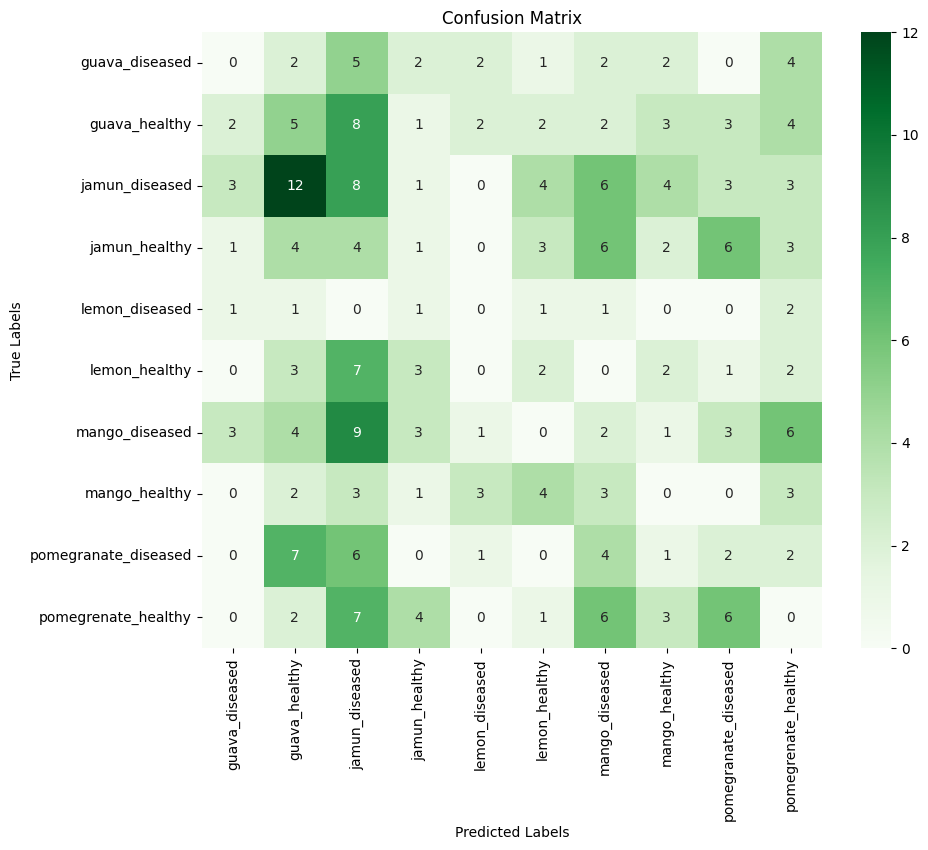

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [115]:
# data = tf.data.Dataset.from_tensor_slices((images, labels))
for image, labels in test_ds:
    arr = labels.numpy()
    arr_expanded = np.expand_dims(arr, axis=0)
    arr2 = np.concatenate(arr_expanded, axis = 0)
    print(arr2)

[5 7 2 0 8 5 7 4 1 8 1 6 6 6 0 9 4 1 8 2 2 1 3 5 3 9 7 6 3 5 3 3]
[3 2 3 7 0 9 1 8 1 1 2 2 1 0 6 1 9 5 6 7 1 3 2 2 7 9 5 9 9 3 9 9]
[8 9 1 7 8 6 9 2 8 7 1 5 6 6 6 3 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8]
[5 3 2 1 8 8 3 3 6 1 2 7 0 6 2 2 1 1 4 6 3 2 3 3 0 6 7 1 3 3 5 3]
[9 0 2 2 5 7 2 3 2 4 3 3 2 4 2 6 8 8 4 3 9 2 4 9 2 4 6 8 9 9 3 2]
[2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3 0 0 2 2 2 0 6]
[6 1 2 3 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 3 1 5 6 8 3 8 3]
[3]


In [116]:
plabel = labels.numpy()
print(plabel)

[3]


In [117]:
predicted_probabilities = model.predict(test_ds)
print(predicted_probabilities)

8/8 [==============================] - 1s 130ms/step
[[6.8898307e-06 1.1908127e-02 7.3513645e-04 ... 2.3659992e-03
  5.5516102e-06 3.5501675e-12]
 [8.5496334e-14 1.1185771e-11 3.5484984e-10 ... 9.9999487e-01
  6.1729783e-15 8.9845530e-13]
 [1.3627467e-04 3.8923935e-03 6.2524283e-01 ... 2.4873841e-06
  5.8421901e-10 5.3864802e-11]
 ...
 [1.1526009e-05 4.2928813e-04 4.5154218e-05 ... 2.9311056e-04
  9.9778467e-01 5.6668714e-04]
 [2.2112286e-05 1.1723476e-04 7.6759271e-02 ... 2.7582233e-04
  2.5695124e-08 2.6183564e-09]
 [2.3043726e-04 3.5189551e-03 1.3410174e-02 ... 8.3206961e-04
  6.5307895e-06 1.2627146e-08]]


In [118]:
predicted_labels = np.argmax(predicted_probabilities, axis=1)
print(predicted_labels)

[5 7 2 6 8 5 7 4 1 9 1 6 6 6 0 9 5 1 8 2 3 1 3 5 2 9 7 6 3 5 3 3 3 2 3 7 0
 9 1 8 1 1 2 6 1 2 6 1 9 5 6 7 1 2 2 2 7 9 5 9 9 3 9 9 8 9 1 7 8 6 9 2 8 7
 1 5 6 6 6 2 2 2 2 3 5 0 1 5 3 0 1 9 3 1 8 8 5 3 2 7 8 8 3 2 6 1 0 7 3 6 3
 2 1 1 5 6 3 1 2 3 2 6 7 1 2 3 5 3 9 0 2 2 5 7 2 3 2 2 3 3 2 5 2 6 8 8 4 3
 9 2 7 9 2 5 6 8 9 9 1 3 2 2 2 4 6 5 5 6 6 1 2 1 1 1 6 9 5 9 6 8 1 6 8 3 3
 0 0 2 3 2 2 6 6 1 2 2 7 6 0 6 7 1 8 9 1 9 1 2 7 5 0 0 1 6 2 9 2 1 5 6 8 3
 8 3 3]
